# Phase 3: Estrous Cycle Detection from Behavioral Data
## A Complete Analysis Following Khatiz et al. (2025) Methodology

---

# Table of Contents

1. [Background & Goals](#1.-Background-&-Goals)
2. [Dataset Overview](#2.-Dataset-Overview)
3. [Setup & Data Loading](#3.-Setup-&-Data-Loading)
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Data Cleaning](#5.-Data-Cleaning)
6. [Analysis Pipeline](#6.-Analysis-Pipeline)
   - 6.1 Hierarchical Clustering of Features
   - 6.2 Factor Analysis
   - 6.3 Principal Component Analysis (PCA)
   - 6.4 K-Means Clustering
7. [K=2 vs K=4 Comparison](#7.-K=2-vs-K=4-Comparison)
8. [Final Results & Recommendations](#8.-Final-Results-&-Recommendations)

---

# 1. Background & Goals

## 1.1 Why Detect Estrous Cycle?

Female mice undergo a **4-5 day estrous cycle** that causes significant hormonal fluctuations. These hormonal changes affect:
- Pain sensitivity
- Drug metabolism
- Behavioral patterns
- Neural activity

**The Problem:** The parent study (Morph2REP) investigates morphine effects in female mice, but didn't collect vaginal cytology (the gold standard for estrous staging). Without knowing the estrous phase, we can't determine if morphine response varies across the cycle.

**Our Solution:** Use behavioral data to *infer* estrous phase, following the methodology of Khatiz et al. (2025), who demonstrated that estrous phases have distinct behavioral signatures.

## 1.2 The Four Estrous Phases

| Phase | Duration | Hormones | Behavioral Signature |
|-------|----------|----------|---------------------|
| **Proestrus** | ~12h | Estrogen rising, LH surge | Moderate-high activity, exploration |
| **Estrus** | ~12h | Estrogen peak, ovulation | **Highest** physical activity, locomotion, climbing |
| **Metestrus** | ~24h | Progesterone rising | Transition to rest, declining activity |
| **Diestrus** | ~48-72h | Low hormones | **Lowest** activity, highest sleep & feeding |

**Expected Distribution (based on phase durations):**
- Proestrus: 10-15%
- Estrus: 10-15%
- Metestrus: 20-25%
- Diestrus: 45-55%

**Simplified Binary View:**
- High Estrogen (Proestrus + Estrus): 20-30%
- Low Estrogen (Metestrus + Diestrus): 70-80%

## 1.3 Khatiz et al. (2025) Key Findings

Khatiz validated behavioral estrous detection using vaginal cytology ground truth:

1. **Estrus females showed 30% more physically demanding activity** than males
2. **Diestrus females had highest sleep-related behaviors**
3. **Five behavioral clusters** emerged from factor analysis:
   - Cluster 1: Feeding & Resource Interaction
   - Cluster 2: Exploratory behaviors
   - Cluster 3: Sleep-Related
   - Cluster 4: Physically Demanding (locomotion, climbing, jumping)
   - Cluster 5: Habituation-Like

**Reference:** Khatiz et al. (2025) Frontiers in Neuroscience 19:1509822

## 1.4 Our Approach

We will:
1. Extract behavioral features from automated monitoring data
2. Apply Khatiz's statistical pipeline (hierarchical clustering, factor analysis, PCA, K-means)
3. Compare K=2 (binary: high vs low activity) vs K=4 (4 estrous phases)
4. Validate clusters against expected biological distributions

**Key Caveat:** Without vaginal cytology, we're creating *behavioral classifications* that we *hypothesize* correspond to estrous phases. We cannot confirm true hormonal status.

---

# 2. Dataset Overview

## 2.1 Study Information

| Parameter | Value |
|-----------|-------|
| Study ID | 1001 (Morph2REP) |
| Data Version | 2025v3.3 |
| Platform | JAX Envision 2025 v3.0 (automated behavioral monitoring) |
| Location | JAX Envision East facility |
| Animals | 54 female C57BL/6J mice (strain 664) |
| Housing | 3 mice per cage, 18 cages total |
| Study Period | January 7 - February 4, 2025 |
| Light Cycle | 12h:12h, lights ON 6:00 AM - 6:00 PM EST |

## 2.2 Treatment Groups

| Group | Rep 1 Cages | Rep 2 Cages | N Mice | Use for Estrous? |
|-------|-------------|-------------|--------|------------------|
| **Vehicle Control** | 4918, 4922, 4923 | 4928, 4929, 4934 | 18 | ✓ YES |
| 5 mg/kg Morphine | 4917, 4921, 4925 | 4927, 4931, 4932 | 18 | ✗ No (drug confound) |
| 25 mg/kg Morphine | 4919, 4920, 4924 | 4926, 4930, 4933 | 18 | ✗ No (drug confound) |

**We only use VEHICLE CONTROLS** for estrous detection to avoid drug effects confounding behavioral patterns.

## 2.3 Experimental Timeline

```
REPLICATE 1 (January 7-22, 2025)
══════════════════════════════════════════════════════════════════════════
Jan 7-9      │ ACCLIMATION (3 days)          │ ⚠️ EXCLUDE - abnormal behavior
Jan 10-13    │ BASELINE (4 days)             │ ✓ Clean behavioral data
Jan 14       │ Morphine Dose #1 (6:00 AM)    │ ✓ Vehicle = no drug
Jan 15       │ CAGE CHANGE (12:00 PM)        │ ⚠️ EXCLUDE - environmental stress
Jan 17       │ Morphine Dose #2 (5:00 PM)    │ ✓ Vehicle = no drug
Jan 18-22    │ Post-treatment monitoring     │ ✓ Clean behavioral data

REPLICATE 2 (January 22 - February 4, 2025)
══════════════════════════════════════════════════════════════════════════
Jan 22-24    │ ACCLIMATION (3 days)          │ ⚠️ EXCLUDE - abnormal behavior
Jan 25-27    │ BASELINE (3 days)             │ ✓ Clean behavioral data
Jan 28       │ Morphine Dose #1 (5:00 PM)    │ ✓ Vehicle = no drug
Jan 29       │ CAGE CHANGE (12:00 PM)        │ ⚠️ EXCLUDE - environmental stress
Jan 31       │ Morphine Dose #2 (6:00 AM)    │ ✓ Vehicle = no drug
Feb 1-2      │ Post-treatment monitoring     │ ✓ Clean behavioral data
Feb 3-4      │ Study termination             │ ⚠️ EXCLUDE - truncated data
```

## 2.4 Behavioral States (Envision System)

The Envision system classifies mouse behavior into discrete states:

| State | Description | Estrous Relevance |
|-------|-------------|-------------------|
| `active` | General activity (moving, not sleeping) | Higher in Estrus |
| `inactive` | Stationary but awake | - |
| `locomotion` | Walking/running | Higher in Estrus |
| `climbing` | Vertical exploration (rearing, hanging) | Higher in Estrus |
| `feeding` | Eating at food hopper | Higher in Diestrus |
| `drinking` | At water bottle | Higher in Diestrus |
| `inferred_sleep` | Sleep (posture + extended inactivity) | Higher in Diestrus |

## 2.5 Data Tables (S3)

```
s3://jax-envision-public-data/study_1001/2025v3.3/tabular/
└── cage_id={cage}/date={date}/{table}.parquet
```

| Table | Description | Key Columns |
|-------|-------------|-------------|
| `animal_bouts.parquet` | Behavioral state bouts | start_time, end_time, state_name, bout_length_seconds |
| `animal_bout_metrics.parquet` | Per-bout metrics | state_name, metric_name (distance), metric_value |

---

# 3. Setup & Data Loading

## 3.1 What We're Doing

Installing and importing the tools needed for analysis:

| Package | Purpose |
|---------|--------|
| `duckdb` | SQL engine that queries Parquet files directly from S3 |
| `pandas` | Data manipulation and analysis |
| `numpy` | Numerical operations |
| `scipy` | Statistical tests (ANOVA, Spearman correlation) |
| `sklearn` | Machine learning (PCA, Factor Analysis, K-Means) |
| `matplotlib/seaborn` | Visualization |

In [35]:
# Install required packages
!pip install duckdb pyarrow scikit-learn scipy seaborn -q

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

# Statistical tools
from scipy import stats
from scipy.stats import spearmanr, f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("All imports successful!")

All imports successful!


## 3.2 Configuration

### What We're Doing
Defining which cages to analyze and which dates to include.

### Why These Choices
- **Vehicle controls only**: Drug-treated mice have altered behavior
- **Post-acclimation only**: First 3 days show abnormal stress/novelty responses
- **Dark cycle focus**: Mice are nocturnal; estrous differences are most visible at night

In [42]:
from datetime import date

# =============================================================================
# CONFIGURATION
# =============================================================================

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

# Vehicle control cages with their analysis windows
# We start AFTER acclimation (3 days) to get clean behavioral data
VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "analysis_start": "2025-01-10",  # After 3-day acclimation (Jan 7-9)
        "analysis_end": "2025-01-22",
        "cage_change": date(2025, 1, 15),
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "analysis_start": "2025-01-25",  # After 3-day acclimation (Jan 22-24)
        "analysis_end": "2025-02-04",
        "cage_change": date(2025, 1, 29),
    },
}

# Additional exclusion dates (spillover + termination)
EXCLUDE_DATES = {
    "Rep1": {date(2025, 1, 9), date(2025, 1, 15)},  # Jan 9 spillover, Jan 15 cage change
    "Rep2": {date(2025, 1, 24), date(2025, 1, 29), date(2025, 2, 3), date(2025, 2, 4)},  # Jan 24 spillover, Jan 29 cage change, Feb 3–4 termination
}

# Light cycle timing (in UTC - data is stored in UTC)
# JAX facility: Lights ON 6:00 AM - 6:00 PM EST
# EST = UTC - 5 hours, so:
#   6 AM EST = 11:00 UTC
#   6 PM EST = 23:00 UTC
LIGHT_START_UTC = 11  # Lights ON
LIGHT_END_UTC = 23    # Lights OFF

print("Configuration:")
print("=" * 60)
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    print(f"  Cages: {cfg['cages']}")
    print(f"  Analysis period: {cfg['analysis_start']} to {cfg['analysis_end']}")
    print(f"  Cage change day: {cfg['cage_change']} (will be excluded)")


Configuration:

Rep1:
  Cages: [4918, 4922, 4923]
  Analysis period: 2025-01-10 to 2025-01-22
  Cage change day: 2025-01-15 (will be excluded)

Rep2:
  Cages: [4928, 4929, 4934]
  Analysis period: 2025-01-25 to 2025-02-04
  Cage change day: 2025-01-29 (will be excluded)


## 3.3 Data Loading Functions

### What We're Doing
Creating a function to load Parquet files from S3 for specific cages and date ranges.

### How It Works
1. Connect to DuckDB with S3 access enabled
2. Loop through each date in the range
3. Construct the S3 path using Hive-style partitioning: `cage_id={cage}/date={date}/`
4. Read Parquet file and concatenate all days

### Why DuckDB + Parquet
- **Parquet**: Columnar format, efficient for analytics
- **DuckDB**: Can query S3 directly without downloading entire files
- **Hive partitioning**: Makes it easy to select specific cages/dates

In [4]:
def load_parquet_s3(cage_id, start_date, end_date, table_name):
    """
    Load parquet table from S3 for a single cage across a date range.
    
    Parameters:
    -----------
    cage_id : int - The cage number (e.g., 4918)
    start_date : str - Start date in 'YYYY-MM-DD' format
    end_date : str - End date in 'YYYY-MM-DD' format
    table_name : str - Name of parquet file (e.g., 'animal_bouts.parquet')
    
    Returns:
    --------
    pd.DataFrame with all data for that cage/date range
    """
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for d in dates:
        date_str = d.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

## 3.4 Load Behavioral Data

### What We're Loading

**`animal_bouts.parquet`**: Each row is a **bout** - a continuous period of one behavioral state.

Example:
```
| animal_id | state_name              | start_time          | bout_length_seconds |
|-----------|-------------------------|---------------------|---------------------|
| 9266      | animal_bouts.locomotion | 2025-01-10 23:15:00 | 45.2                |
| 9266      | animal_bouts.feeding    | 2025-01-10 23:15:45 | 120.5               |
```

**`animal_bout_metrics.parquet`**: Distance traveled during each bout.

### Why We Need Both
- **Bouts**: Time spent in each behavior (Khatiz's primary measure)
- **Metrics**: Distance traveled (exploration, a key estrous marker)

In [5]:
# Load animal_bouts.parquet
print("Loading animal_bouts.parquet...")
print("="*60)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} bouts")
        else:
            print("No data")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\nTotal bouts: {len(df_bouts):,}")

Loading animal_bouts.parquet...

Rep1:
  Cage 4918... 2,201,519 bouts
  Cage 4922... 2,039,081 bouts
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,117,667 bouts

Rep2:
  Cage 4928... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,872,654 bouts
  Cage 4929... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,688,050 bouts
  Cage 4934... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,795,480 bouts

Total bouts: 11,714,451


In [6]:
# Load animal_bout_metrics.parquet (distance traveled)
print("Loading animal_bout_metrics.parquet...")
print("="*60)

all_metrics = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bout_metrics.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_metrics.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bout_metrics = pd.concat(all_metrics, ignore_index=True)
print(f"\nTotal metrics: {len(df_bout_metrics):,}")

Loading animal_bout_metrics.parquet...

Rep1:
  Cage 4918... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,846,264 rows
  Cage 4922... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,804,600 rows
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,809,819 rows

Rep2:
  Cage 4928... 1,625,405 rows
  Cage 4929... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,496,873 rows
  Cage 4934... 1,590,462 rows

Total metrics: 10,173,423


In [7]:
# Inspect available behavioral states
print("Behavioral states in data:")
print("="*50)
for state, count in df_bouts['state_name'].value_counts().items():
    print(f"  {state}: {count:,} bouts")

Behavioral states in data:
  animal_bouts.social.in_proximity_other: 4,228,593 bouts
  animal_bouts.social.isolated_other: 2,674,221 bouts
  animal_bouts.active: 1,340,775 bouts
  animal_bouts.social.proximal_all: 1,063,945 bouts
  animal_bouts.inactive: 939,711 bouts
  animal_bouts.social.isolated_all: 621,258 bouts
  animal_bouts.locomotion: 457,610 bouts
  animal_bouts.climbing: 178,953 bouts
  animal_bouts.feeding: 158,279 bouts
  animal_bouts.inferred_sleep: 32,415 bouts
  animal_bouts.drinking: 18,691 bouts


---

# 4. Feature Engineering

## 4.1 Concept: Why Compute Features?

Raw bout data has thousands of rows per animal per day. We need to **summarize** this into meaningful features:

| Feature Type | What It Measures | Example |
|--------------|------------------|--------|
| **Duration** | Total time in a state | "Mouse spent 3,600s locomoting" |
| **Bout Count** | Number of bouts | "Mouse had 45 locomotion bouts" |
| **Mean Bout Length** | Average bout duration | "Average locomotion bout was 80s" |
| **Distance** | Total distance traveled | "Mouse traveled 50,000 units" |
| **Derived** | Combinations | "Physically demanding = locomotion + climbing" |

## 4.2 Time Periods

Khatiz analyzed behavior separately for:
- **Dark cycle** (6 PM - 6 AM): When mice are active; estrous differences most visible
- **Light cycle** (6 AM - 6 PM): Rest period
- **24-hour**: Full day summary

**We focus on DARK CYCLE** because mice are nocturnal and Khatiz found the strongest estrous signals during active periods.

## 4.3 Night Date Assignment

**Important nuance:** A "night" spans two calendar dates:
- Night of Jan 10 = 6 PM Jan 10 → 6 AM Jan 11

For bouts occurring after midnight (e.g., 2 AM Jan 11), we assign them to the "night of Jan 10" since they're part of the same dark cycle.

In [8]:
def compute_dark_cycle_features(df_bouts, df_metrics):
    """
    Compute behavioral features for dark cycle (6 PM - 6 AM EST).
    
    This function:
    1. Filters to dark cycle bouts only
    2. Assigns each bout to a "night" (spanning 2 calendar dates)
    3. Aggregates by animal and night
    4. Computes duration, bout count, mean bout length for each state
    5. Merges distance metrics
    6. Computes derived features (physically_demanding, sleep_related, etc.)
    
    Returns:
    --------
    DataFrame with one row per animal-night, columns for each feature
    """
    
    # State name mapping (short name -> full name in data)
    STATE_MAP = {
        'active': 'animal_bouts.active',
        'inactive': 'animal_bouts.inactive',
        'locomotion': 'animal_bouts.locomotion',
        'feeding': 'animal_bouts.feeding',
        'drinking': 'animal_bouts.drinking',
        'climbing': 'animal_bouts.climbing',
        'inferred_sleep': 'animal_bouts.inferred_sleep',
    }
    
    # =========================================================================
    # STEP 1: Parse timestamps and identify dark cycle
    # =========================================================================
    df_b = df_bouts.copy()
    df_b['start_time'] = pd.to_datetime(df_b['start_time'])
    df_b['hour_utc'] = df_b['start_time'].dt.hour
    
    # Dark cycle: NOT between 11:00-23:00 UTC (i.e., before 11 or after 23)
    # This is 6PM-6AM EST
    df_b['is_dark'] = ~((df_b['hour_utc'] >= LIGHT_START_UTC) & (df_b['hour_utc'] < LIGHT_END_UTC))
    
    # Filter to dark cycle only
    df_b = df_b[df_b['is_dark']].copy()
    
    # =========================================================================
    # STEP 2: Assign night date
    # Bouts after midnight belong to the previous calendar day's "night"
    # =========================================================================
    df_b['night_date'] = df_b['start_time'].dt.date
    # If hour < 11 UTC (before 6 AM EST), it's part of previous night
    mask_early = df_b['hour_utc'] < LIGHT_START_UTC
    df_b.loc[mask_early, 'night_date'] = (df_b.loc[mask_early, 'start_time'] - timedelta(days=1)).dt.date
    
    # =========================================================================
    # STEP 3: Aggregate bouts by animal and night
    # =========================================================================
    results = []
    for (cage_id, animal_id, night), grp in df_b.groupby(['cage_id', 'animal_id', 'night_date']):
        row = {
            'cage_id': cage_id,
            'animal_id': animal_id,
            'night_date': night,
        }
        
        # For each behavioral state
        for short_name, full_name in STATE_MAP.items():
            state_df = grp[grp['state_name'] == full_name]
            row[f'{short_name}_duration'] = state_df['bout_length_seconds'].sum()
            row[f'{short_name}_bout_count'] = len(state_df)
            row[f'{short_name}_mean_bout'] = state_df['bout_length_seconds'].mean() if len(state_df) > 0 else 0
        
        row['total_duration'] = grp['bout_length_seconds'].sum()
        results.append(row)
    
    df_summary = pd.DataFrame(results)
    
    # =========================================================================
    # STEP 4: Process distance metrics
    # =========================================================================
    df_m = df_metrics.copy()
    df_m['start_time'] = pd.to_datetime(df_m['start_time'])
    df_m['hour_utc'] = df_m['start_time'].dt.hour
    df_m['is_dark'] = ~((df_m['hour_utc'] >= LIGHT_START_UTC) & (df_m['hour_utc'] < LIGHT_END_UTC))
    df_m = df_m[df_m['is_dark']].copy()
    
    df_m['night_date'] = df_m['start_time'].dt.date
    mask_early = df_m['hour_utc'] < LIGHT_START_UTC
    df_m.loc[mask_early, 'night_date'] = (df_m.loc[mask_early, 'start_time'] - timedelta(days=1)).dt.date
    
    dist_results = []
    for (cage_id, animal_id, night), grp in df_m.groupby(['cage_id', 'animal_id', 'night_date']):
        row = {'cage_id': cage_id, 'animal_id': animal_id, 'night_date': night}
        row['total_distance'] = grp['metric_value'].sum()
        for short_name, full_name in STATE_MAP.items():
            state_df = grp[grp['state_name'] == full_name]
            row[f'{short_name}_distance'] = state_df['metric_value'].sum()
        dist_results.append(row)
    
    df_dist = pd.DataFrame(dist_results)
    if len(df_dist) > 0:
        df_summary = df_summary.merge(df_dist, on=['cage_id', 'animal_id', 'night_date'], how='left')
    
    # =========================================================================
    # STEP 5: Compute derived features (matching Khatiz's behavioral clusters)
    # =========================================================================
    
    # Physically demanding = locomotion + climbing
    # Khatiz Cluster 4: High in Estrus
    df_summary['physically_demanding'] = df_summary['locomotion_duration'] + df_summary['climbing_duration']
    
    # Sleep-related
    # Khatiz Cluster 3: High in Diestrus
    df_summary['sleep_related'] = df_summary['inferred_sleep_duration']
    
    # Feeding/resourcing = feeding + drinking
    # Khatiz Cluster 1: High in Diestrus
    df_summary['feeding_resourcing'] = df_summary['feeding_duration'] + df_summary['drinking_duration']
    
    # Activity amplitude = overall activity level
    df_summary['activity_amplitude'] = df_summary['active_duration'] + df_summary['locomotion_duration']
    
    # Fragmentation = more bouts per unit time = more transitions
    # Higher fragmentation may indicate different behavioral organization
    df_summary['sleep_fragmentation'] = df_summary['inferred_sleep_bout_count'] / (df_summary['inferred_sleep_duration'] + 1)
    df_summary['active_fragmentation'] = df_summary['active_bout_count'] / (df_summary['active_duration'] + 1)
    
    # Exploration intensity = distance per unit activity time
    if 'total_distance' in df_summary.columns:
        df_summary['exploration_intensity'] = df_summary['total_distance'] / (df_summary['activity_amplitude'] + 1)
    
    return df_summary

print("Feature engineering function defined.")

Feature engineering function defined.


In [9]:
# Compute features for dark cycle
print("Computing dark cycle features...")
print("="*60)

df_features = compute_dark_cycle_features(df_bouts, df_bout_metrics)

# Remove tracking errors (animal_id = 0 means unidentified)
df_features = df_features[df_features['animal_id'] != 0].copy()

print(f"\nResult: {len(df_features)} animal-nights")
print(f"Animals: {df_features['animal_id'].nunique()}")
print(f"Cages: {df_features['cage_id'].nunique()}")
print(f"Date range: {df_features['night_date'].min()} to {df_features['night_date'].max()}")

Computing dark cycle features...

Result: 222 animal-nights
Animals: 18
Cages: 6
Date range: 2025-01-09 to 2025-02-04


---

# 5. Data Cleaning

## 5.1 Why Clean the Data?

Raw experimental data contains artifacts that can confuse our analysis:

| Issue | Days Affected | Problem | Solution |
|-------|---------------|---------|----------|
| **Acclimation spillover** | Jan 9, Jan 24 | Early morning hours of first analysis day contain acclimation behavior | Exclude |
| **Cage changes** | Jan 15, Jan 29 | Environmental stress causes abnormal behavior | Exclude |
| **Study termination** | Feb 3-4 | Truncated data collection | Exclude |

## 5.2 Identify Problematic Days

In [10]:
# Check data completeness by date
print("Data completeness check:")
print("="*70)
print("Expected dark cycle duration: ~43,200 seconds (12 hours)")
print("")

date_totals = df_features.groupby('night_date')['total_duration'].agg(['mean', 'count'])
date_totals.columns = ['mean_duration', 'n_animals']
date_totals['pct_expected'] = 100 * date_totals['mean_duration'] / 80000  # Approximate expected

print(date_totals.to_string())

# Flag problematic dates
print("\n" + "="*70)
print("PROBLEMATIC DATES:")
print("="*70)
for idx, row in date_totals.iterrows():
    if row['mean_duration'] < 60000:  # Less than ~75% of expected
        print(f"  {idx}: {row['mean_duration']:.0f}s ({row['pct_expected']:.0f}% of expected) - TRUNCATED")

Data completeness check:
Expected dark cycle duration: ~43,200 seconds (12 hours)

            mean_duration  n_animals  pct_expected
night_date                                        
2025-01-09   72717.777778          9     90.897222
2025-01-10   80212.444444          9    100.265556
2025-01-11   79168.000000          9     98.960000
2025-01-12   79677.111111          9     99.596389
2025-01-13   82193.555556          9    102.741944
2025-01-14   83662.333333          9    104.577917
2025-01-15   82656.000000          9    103.320000
2025-01-16   83540.111111          9    104.425139
2025-01-17   84037.444444          9    105.046806
2025-01-18   81926.888889          9    102.408611
2025-01-19   83462.222222          9    104.327778
2025-01-20   80968.777778          9    101.210972
2025-01-21   78584.333333          9     98.230417
2025-01-24   69141.888889          9     86.427361
2025-01-25   73637.222222          9     92.046528
2025-01-26   79433.666667          9     99.292083

## 5.3 Define Exclusions

Based on our analysis, we exclude:

1. **Cage change days**: Jan 15 (Rep1), Jan 29 (Rep2)
   - Mice are stressed from new environment
   - Behavior is abnormal for 24-48 hours

2. **Truncated end-of-study days**: Feb 3-4
   - Data collection ended before full dark cycle
   - Severely incomplete data (some only 8% of expected)

3. **Acclimation spillover** (if present): Jan 9, Jan 24
   - Early morning hours may contain acclimation behavior

In [11]:
# Define dates to exclude
EXCLUDE_DATES = [
    # Cage change days
    date(2025, 1, 15),  # Rep 1 cage change
    date(2025, 1, 29),  # Rep 2 cage change
    
    # Truncated end-of-study days
    date(2025, 2, 3),   # 72% data
    date(2025, 2, 4),   # 8% data - severely truncated
    
    # Acclimation spillover (if present)
    date(2025, 1, 9),   # Rep 1 acclimation night
    date(2025, 1, 24),  # Rep 2 acclimation night
]

print("Dates to exclude:")
for d in EXCLUDE_DATES:
    reason = {
        date(2025, 1, 15): "Rep 1 cage change",
        date(2025, 1, 29): "Rep 2 cage change",
        date(2025, 2, 3): "Truncated (72%)",
        date(2025, 2, 4): "Severely truncated (8%)",
        date(2025, 1, 9): "Rep 1 acclimation spillover",
        date(2025, 1, 24): "Rep 2 acclimation spillover",
    }.get(d, "Unknown")
    print(f"  {d}: {reason}")

Dates to exclude:
  2025-01-15: Rep 1 cage change
  2025-01-29: Rep 2 cage change
  2025-02-03: Truncated (72%)
  2025-02-04: Severely truncated (8%)
  2025-01-09: Rep 1 acclimation spillover
  2025-01-24: Rep 2 acclimation spillover


In [12]:
# Apply exclusions
df_clean = df_features[~df_features['night_date'].isin(EXCLUDE_DATES)].copy()

print("Data cleaning results:")
print("="*50)
print(f"Before: {len(df_features)} animal-nights")
print(f"After:  {len(df_clean)} animal-nights")
print(f"Removed: {len(df_features) - len(df_clean)} animal-nights")

print(f"\nRemaining date range: {df_clean['night_date'].min()} to {df_clean['night_date'].max()}")
print(f"Remaining animals: {df_clean['animal_id'].nunique()}")

Data cleaning results:
Before: 222 animal-nights
After:  171 animal-nights
Removed: 51 animal-nights

Remaining date range: 2025-01-10 to 2025-02-02
Remaining animals: 18


In [13]:
# Verify cleaning worked
print("Verification: Data completeness after cleaning")
print("="*70)

clean_totals = df_clean.groupby('night_date')['total_duration'].mean()
print(f"Min mean duration: {clean_totals.min():.0f}s")
print(f"Max mean duration: {clean_totals.max():.0f}s")
print(f"All days > 60,000s: {(clean_totals > 60000).all()}")

Verification: Data completeness after cleaning
Min mean duration: 73637s
Max mean duration: 84037s
All days > 60,000s: True


---

# 6. Analysis Pipeline

Now we apply Khatiz's methodology to classify nights into estrous phases.

## Overview of the Pipeline

```
┌─────────────────────────────────────────────────────────────────────┐
│  1. SELECT FEATURES                                                 │
│     Choose behavioral metrics relevant to estrous detection         │
├─────────────────────────────────────────────────────────────────────┤
│  2. STANDARDIZE                                                     │
│     Put all features on same scale (z-score)                        │
├─────────────────────────────────────────────────────────────────────┤
│  3. HIERARCHICAL CLUSTERING OF FEATURES                             │
│     See which behaviors co-vary (feature relationships)             │
├─────────────────────────────────────────────────────────────────────┤
│  4. FACTOR ANALYSIS                                                 │
│     Find underlying behavioral dimensions                           │
├─────────────────────────────────────────────────────────────────────┤
│  5. PCA                                                             │
│     Reduce dimensionality for visualization                         │
├─────────────────────────────────────────────────────────────────────┤
│  6. K-MEANS CLUSTERING OF NIGHTS                                    │
│     Group nights by behavioral similarity                           │
├─────────────────────────────────────────────────────────────────────┤
│  7. LABEL CLUSTERS                                                  │
│     Assign estrous phase names based on behavioral signatures       │
├─────────────────────────────────────────────────────────────────────┤
│  8. VALIDATE                                                        │
│     Statistical tests (ANOVA) to confirm clusters differ            │
└─────────────────────────────────────────────────────────────────────┘
```

## 6.1 Feature Selection

### What We're Doing
Selecting which features to include in clustering.

### Selection Criteria
- **Biologically relevant**: Features Khatiz found to differ by estrous phase
- **Non-redundant**: Avoid including highly correlated features
- **Available**: Must exist in our data

In [14]:
# Select features for analysis
FEATURES = [
    # Duration features (total time in each state)
    'active_duration', 'inactive_duration', 'locomotion_duration',
    'feeding_duration', 'drinking_duration', 'climbing_duration', 'inferred_sleep_duration',
    
    # Bout features (how behavior is organized)
    'active_bout_count', 'locomotion_bout_count', 'climbing_bout_count', 'inferred_sleep_bout_count',
    
    # Derived features (matching Khatiz clusters)
    'physically_demanding',   # locomotion + climbing - HIGH in Estrus
    'sleep_related',          # sleep duration - HIGH in Diestrus
    'feeding_resourcing',     # feeding + drinking - HIGH in Diestrus
    'activity_amplitude',     # overall activity level
    
    # Fragmentation features
    'sleep_fragmentation',
    'active_fragmentation',
    
    # Distance/exploration features
    'total_distance',
    'locomotion_distance',
    'climbing_distance',
    'exploration_intensity',
]

# Keep only features that exist
FEATURES = [f for f in FEATURES if f in df_clean.columns]

print(f"Selected {len(FEATURES)} features:")
print("="*50)
for i, f in enumerate(FEATURES, 1):
    print(f"  {i:2d}. {f}")

Selected 21 features:
   1. active_duration
   2. inactive_duration
   3. locomotion_duration
   4. feeding_duration
   5. drinking_duration
   6. climbing_duration
   7. inferred_sleep_duration
   8. active_bout_count
   9. locomotion_bout_count
  10. climbing_bout_count
  11. inferred_sleep_bout_count
  12. physically_demanding
  13. sleep_related
  14. feeding_resourcing
  15. activity_amplitude
  16. sleep_fragmentation
  17. active_fragmentation
  18. total_distance
  19. locomotion_distance
  20. climbing_distance
  21. exploration_intensity


## 6.2 Standardization

### What We're Doing
Converting all features to z-scores: `z = (x - mean) / std`

### Why Standardize?

Different features have different scales:
- `locomotion_duration` might range from 0 to 5,000 seconds
- `sleep_fragmentation` might range from 0 to 0.1

Without standardization, features with larger values would dominate:
- Distance calculations would be driven by `locomotion_duration`
- K-means would ignore `sleep_fragmentation`

After standardization, each feature has:
- Mean = 0
- Standard deviation = 1

### Intuition
Think of it like converting different currencies to a common unit. You can't compare 1,000 yen to 10 dollars without conversion. Standardization converts all features to "standard units."

In [15]:
# Prepare data: remove rows with missing values and standardize
df_analysis = df_clean.dropna(subset=FEATURES).copy()
X = df_analysis[FEATURES].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardization results:")
print("="*50)
print(f"Observations (animal-nights): {X_scaled.shape[0]}")
print(f"Features: {X_scaled.shape[1]}")
print(f"")
print(f"After standardization:")
print(f"  Mean of each feature: {X_scaled.mean(axis=0).mean():.6f} (should be ~0)")
print(f"  Std of each feature:  {X_scaled.std(axis=0).mean():.6f} (should be ~1)")

Standardization results:
Observations (animal-nights): 171
Features: 21

After standardization:
  Mean of each feature: 0.000000 (should be ~0)
  Std of each feature:  1.000000 (should be ~1)


## 6.3 Hierarchical Clustering of FEATURES

### What We're Doing
Clustering the **features** (not nights!) to see which behaviors co-vary.

### Method
1. Compute **Spearman correlation** between all pairs of features
2. Convert to distance: `distance = 1 - correlation`
3. Apply **complete linkage** hierarchical clustering
4. Visualize as dendrogram

### Why Spearman (not Pearson)?
- Spearman uses **ranks**, not raw values
- Robust to outliers and non-normal distributions
- Behavioral data is often skewed (many zeros, some high values)

### How to Read the Dendrogram
- **Y-axis**: Distance (1 - correlation)
- Features that join at **low height** are highly correlated
- Features that join at **high height** are less related
- Clusters form where branches split

### What to Look For
We expect to see clusters matching Khatiz's findings:
- Activity features together (locomotion, climbing, active)
- Rest features together (sleep, inactive)
- Feeding features together (feeding, drinking)

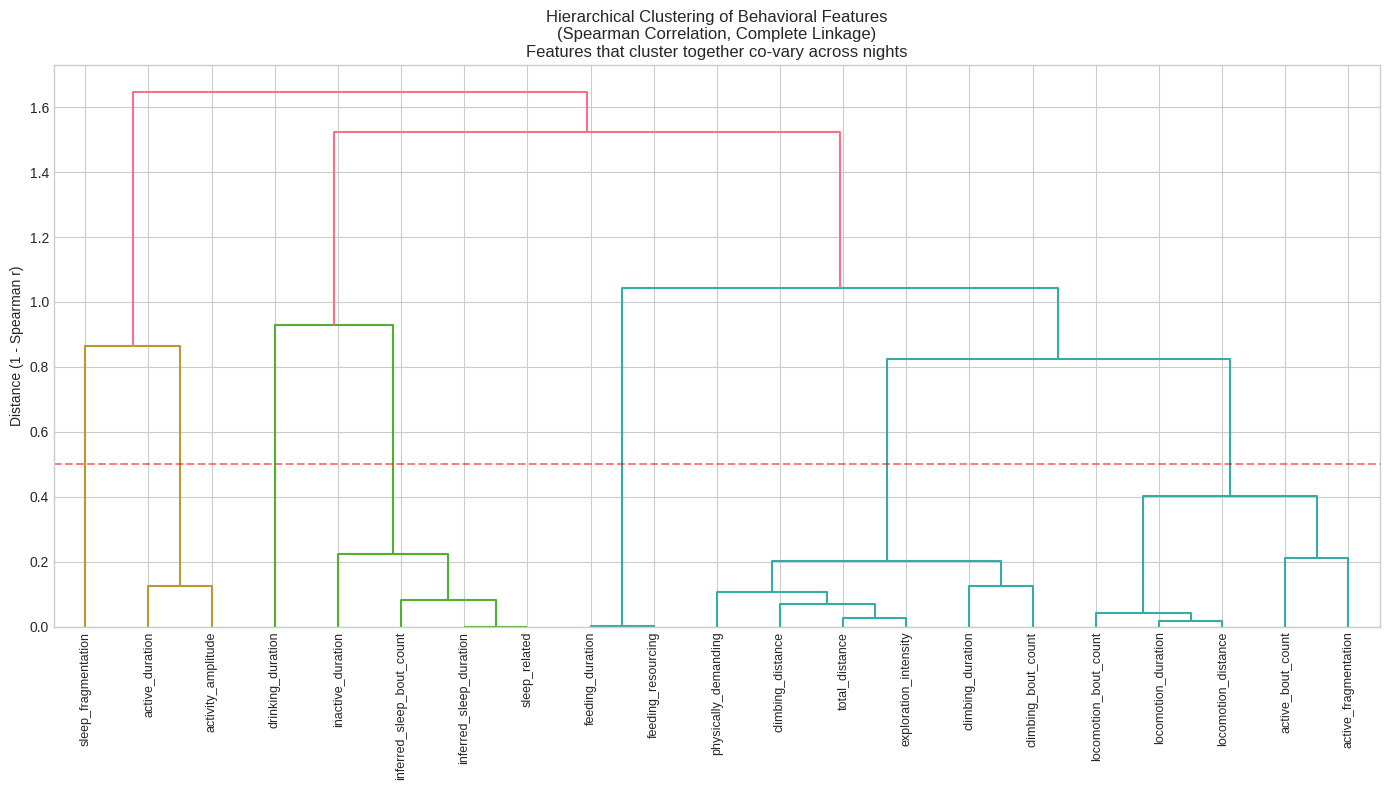


Interpretation:
• Features joining at LOW height are highly correlated (co-vary together)
• Features joining at HIGH height are less related
• Look for clusters of activity features vs rest features


In [16]:
# Hierarchical clustering of FEATURES
# This groups features that co-vary together across nights

# Step 1: Compute Spearman correlation matrix
corr_matrix = df_analysis[FEATURES].corr(method='spearman')

# Step 2: Convert to distance
distance_matrix = 1 - corr_matrix

# Step 3: Hierarchical clustering
linkage_features = linkage(squareform(distance_matrix), method='complete')

# Step 4: Plot dendrogram
fig, ax = plt.subplots(figsize=(14, 8))
dendrogram(
    linkage_features,
    labels=FEATURES,
    leaf_rotation=90,
    leaf_font_size=9,
    ax=ax
)
ax.set_title('Hierarchical Clustering of Behavioral Features\n'
             '(Spearman Correlation, Complete Linkage)\n'
             'Features that cluster together co-vary across nights', fontsize=12)
ax.set_ylabel('Distance (1 - Spearman r)')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Potential cut height')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Features joining at LOW height are highly correlated (co-vary together)")
print("• Features joining at HIGH height are less related")
print("• Look for clusters of activity features vs rest features")

## 6.4 Factor Analysis (Varimax Rotation)

### What We're Doing
Finding underlying **latent dimensions** (factors) that explain the variation in all features.

### Intuition
Instead of 21 separate features, we ask: "What are the underlying behavioral dimensions?"

For example, Khatiz found 7 factors:
1. Exploratory (Hang, Walk, Climb)
2. Foraging (Dig, Sniff)
3. Postural-Locomotor (Rear Up, Come Down)
4. Sleep-Related (Sleep, Groom, Pause)
5. Physically Demanding (Jump, Land)
6. Pre/Post Sleep (Awaken, Twitch)
7. Nourishment (Eat, Drink)

### Varimax Rotation
Makes factors easier to interpret by:
- Maximizing variance of loadings within each factor
- Each factor has a few HIGH loadings and many LOW loadings
- Cleaner interpretation: "Factor 1 = locomotion and climbing"

### How to Read Loadings
- **Loading**: How strongly a feature is associated with a factor
- |loading| > 0.3 is typically considered meaningful
- Positive loading: Feature increases with factor
- Negative loading: Feature decreases with factor

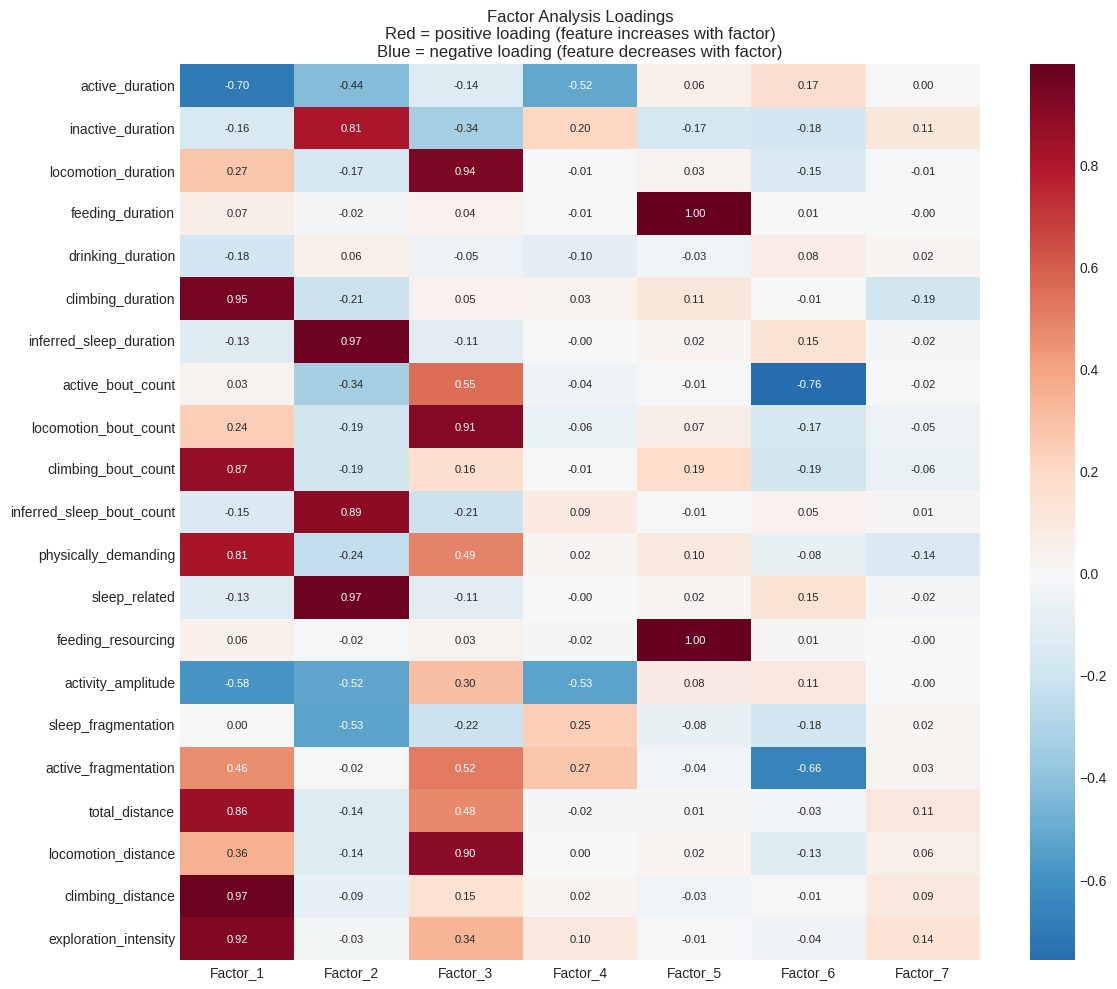


Factor Interpretation (|loading| > 0.25):

Factor_1:
  HIGH: climbing_distance (+0.97), climbing_duration (+0.95), exploration_intensity (+0.92)
  LOW:  active_duration (-0.70), activity_amplitude (-0.58)

Factor_2:
  HIGH: inferred_sleep_duration (+0.97), sleep_related (+0.97), inferred_sleep_bout_count (+0.89)
  LOW:  sleep_fragmentation (-0.53), activity_amplitude (-0.52), active_duration (-0.44)

Factor_3:
  HIGH: locomotion_duration (+0.94), locomotion_bout_count (+0.91), locomotion_distance (+0.90)
  LOW:  inactive_duration (-0.34)

Factor_4:
  HIGH: active_fragmentation (+0.27)
  LOW:  activity_amplitude (-0.53), active_duration (-0.52)

Factor_5:
  HIGH: feeding_resourcing (+1.00), feeding_duration (+1.00)

Factor_6:
  LOW:  active_bout_count (-0.76), active_fragmentation (-0.66)

Factor_7:


In [17]:
# Factor Analysis with Varimax rotation
n_factors = min(7, len(FEATURES) - 1)

fa = FactorAnalysis(n_components=n_factors, rotation='varimax', random_state=42)
fa.fit(X_scaled)

# Extract loadings
loadings = pd.DataFrame(
    fa.components_.T,
    index=FEATURES,
    columns=[f'Factor_{i+1}' for i in range(n_factors)]
)

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    loadings,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    ax=ax,
    annot_kws={'size': 8}
)
ax.set_title('Factor Analysis Loadings\n'
             'Red = positive loading (feature increases with factor)\n'
             'Blue = negative loading (feature decreases with factor)', fontsize=12)
plt.tight_layout()
plt.show()

# Interpret factors
print("\nFactor Interpretation (|loading| > 0.25):")
print("="*60)
for i in range(n_factors):
    col = f'Factor_{i+1}'
    top_pos = loadings[col].nlargest(3)
    top_neg = loadings[col].nsmallest(3)
    
    print(f"\n{col}:")
    high = [f"{idx} ({val:+.2f})" for idx, val in top_pos.items() if abs(val) > 0.25]
    low = [f"{idx} ({val:+.2f})" for idx, val in top_neg.items() if abs(val) > 0.25]
    
    if high:
        print(f"  HIGH: {', '.join(high)}")
    if low:
        print(f"  LOW:  {', '.join(low)}")

## 6.5 Principal Component Analysis (PCA)

### What We're Doing
Reducing the dimensionality of the data for visualization.

### How PCA Works
1. Find the direction of **maximum variance** in the data → PC1
2. Find the direction **perpendicular to PC1** with maximum variance → PC2
3. Continue for more components

### Intuition
Imagine a cloud of points in 21-dimensional space (21 features). PCA finds the "best angle" to view this cloud in 2D, preserving as much of the original structure as possible.

### What to Look For
- **Variance explained**: How much information is captured by each PC
- **Separation**: Do we see distinct clusters in PC1 vs PC2 space?
- **Gradients**: Is there a continuous gradient (suggesting continuous variation) or discrete groups?

### Expectations
If estrous phases are behaviorally distinct, we should see some separation. However, Levy et al. (2023) found estrous explains only ~3% of behavioral variance, so don't expect dramatic separation.

In [18]:
# PCA
pca = PCA(n_components=min(10, len(FEATURES)))
X_pca = pca.fit_transform(X_scaled)

# Add PC coordinates to dataframe
for i in range(min(5, X_pca.shape[1])):
    df_analysis[f'PC{i+1}'] = X_pca[:, i]

# Print variance explained
print("PCA Results:")
print("="*60)
print("\nVariance explained by each principal component:")
cumulative = 0
for i, var in enumerate(pca.explained_variance_ratio_[:7]):
    cumulative += var
    bar = '█' * int(var * 50)
    print(f"  PC{i+1}: {var*100:5.1f}% {bar}  (cumulative: {cumulative*100:5.1f}%)")

print(f"\nFirst 2 PCs explain {pca.explained_variance_ratio_[:2].sum()*100:.1f}% of variance")
print(f"First 5 PCs explain {pca.explained_variance_ratio_[:5].sum()*100:.1f}% of variance")

PCA Results:

Variance explained by each principal component:
  PC1:  43.0% █████████████████████  (cumulative:  43.0%)
  PC2:  21.3% ██████████  (cumulative:  64.2%)
  PC3:  10.5% █████  (cumulative:  74.8%)
  PC4:  10.1% █████  (cumulative:  84.9%)
  PC5:   5.6% ██  (cumulative:  90.5%)
  PC6:   4.3% ██  (cumulative:  94.8%)
  PC7:   2.4% █  (cumulative:  97.3%)

First 2 PCs explain 64.2% of variance
First 5 PCs explain 90.5% of variance


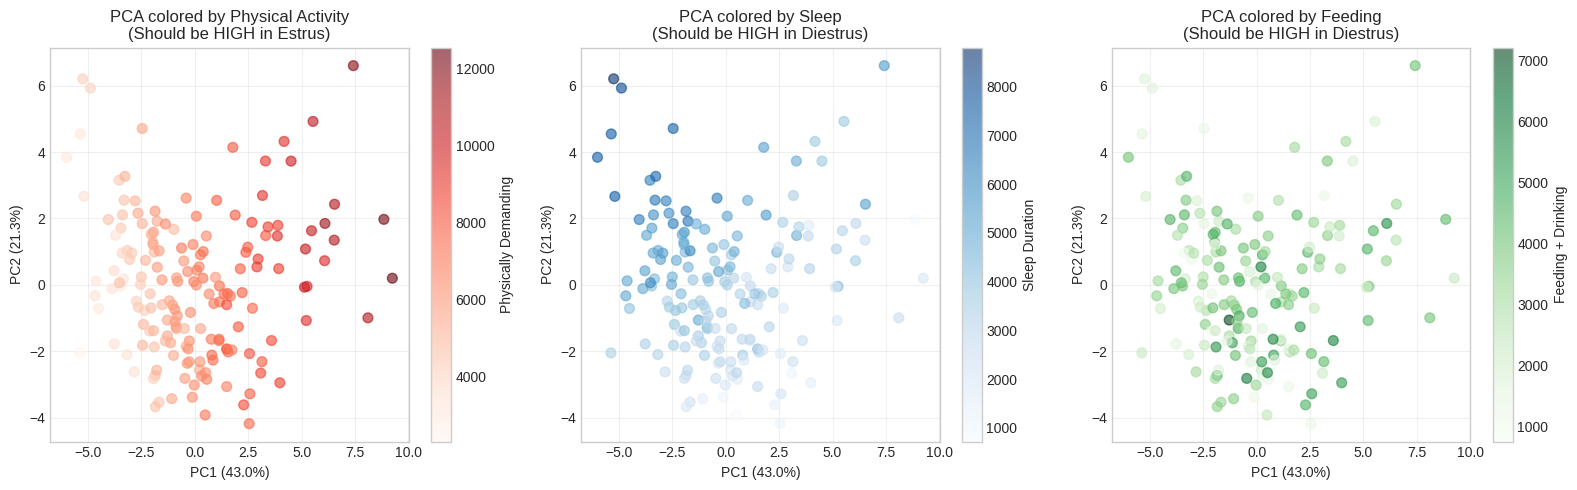


Interpretation:
• Look for gradients: Do colors change smoothly across the plot?
• Look for clusters: Are there distinct groups?
• Activity and sleep should show opposite patterns (negative correlation)


In [19]:
# Visualize PCA with behavioral gradients
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Colored by physical activity
ax = axes[0]
sc = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                c=df_analysis['physically_demanding'], cmap='Reds', alpha=0.6, s=50)
plt.colorbar(sc, ax=ax, label='Physically Demanding')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA colored by Physical Activity\n(Should be HIGH in Estrus)')
ax.grid(True, alpha=0.3)

# Plot 2: Colored by sleep
ax = axes[1]
sc = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                c=df_analysis['sleep_related'], cmap='Blues', alpha=0.6, s=50)
plt.colorbar(sc, ax=ax, label='Sleep Duration')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA colored by Sleep\n(Should be HIGH in Diestrus)')
ax.grid(True, alpha=0.3)

# Plot 3: Colored by feeding
ax = axes[2]
sc = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                c=df_analysis['feeding_resourcing'], cmap='Greens', alpha=0.6, s=50)
plt.colorbar(sc, ax=ax, label='Feeding + Drinking')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA colored by Feeding\n(Should be HIGH in Diestrus)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Look for gradients: Do colors change smoothly across the plot?")
print("• Look for clusters: Are there distinct groups?")
print("• Activity and sleep should show opposite patterns (negative correlation)")

## 6.6 K-Means Clustering

### What We're Doing
Grouping the **nights** (not features!) into clusters based on behavioral similarity.

### How K-Means Works
1. Randomly initialize K cluster centers
2. Assign each night to the nearest center (Euclidean distance in standardized feature space)
3. Update centers to be the mean of assigned points
4. Repeat until convergence

### Choosing K
- **K=2**: Binary classification (high vs low activity)
- **K=4**: Four estrous phases (Proestrus, Estrus, Metestrus, Diestrus)
- **Optimal K**: Determined by silhouette score

### Silhouette Score
Measures how well-separated clusters are:
- **1.0**: Perfect separation (each point far from other clusters)
- **0.0**: Overlapping clusters (points on cluster boundaries)
- **< 0**: Points likely assigned to wrong cluster

**Interpretation guidelines:**
- 0.71-1.0: Strong structure
- 0.51-0.70: Reasonable structure
- 0.26-0.50: Weak structure
- < 0.25: No substantial structure

In [20]:
# Test different K values
print("Finding Optimal K:")
print("="*70)

k_range = range(2, 8)
silhouettes = []
inertias = []

print(f"{'k':<5} {'Silhouette':<12} {'Inertia':<15} {'Interpretation'}")
print("-"*70)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    inertias.append(km.inertia_)
    
    interp = {
        2: "Binary: High vs Low activity",
        3: "Three behavioral states",
        4: "Four estrous phases (P, E, M, D)",
        5: "Khatiz used this (4 + male)",
        6: "Too many for 4-phase cycle",
        7: "Too many"
    }.get(k, "")
    
    marker = " ← OPTIMAL" if sil == max(silhouettes) else ""
    print(f"{k:<5} {sil:<12.3f} {km.inertia_:<15.1f} {interp}{marker}")

optimal_k = k_range[np.argmax(silhouettes)]
print("-"*70)
print(f"\nStatistically optimal k: {optimal_k} (highest silhouette)")
print(f"Biologically meaningful k: 4 (matches 4 estrous phases)")

Finding Optimal K:
k     Silhouette   Inertia         Interpretation
----------------------------------------------------------------------
2     0.266        2585.4          Binary: High vs Low activity ← OPTIMAL
3     0.212        2085.7          Three behavioral states
4     0.179        1894.5          Four estrous phases (P, E, M, D)
5     0.185        1716.7          Khatiz used this (4 + male)
6     0.158        1591.5          Too many for 4-phase cycle
7     0.157        1513.1          Too many
----------------------------------------------------------------------

Statistically optimal k: 2 (highest silhouette)
Biologically meaningful k: 4 (matches 4 estrous phases)


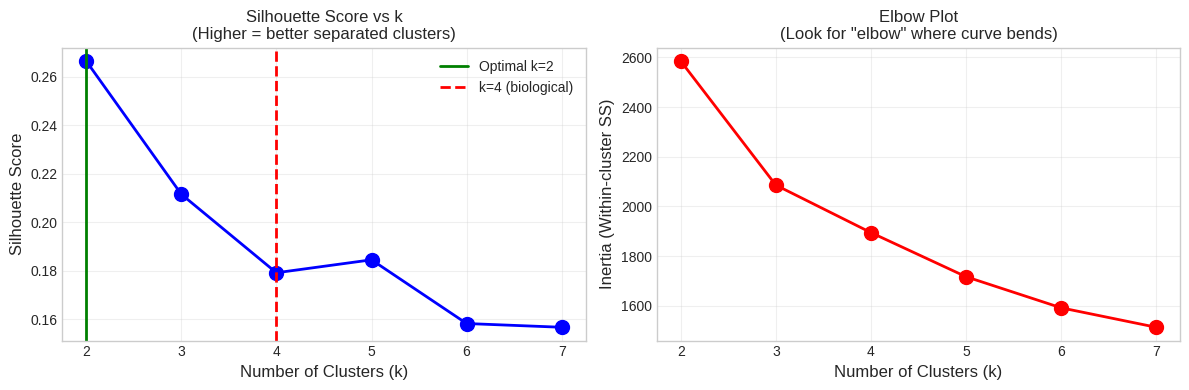

In [21]:
# Visualize k selection
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Silhouette plot
ax = axes[0]
ax.plot(list(k_range), silhouettes, 'bo-', markersize=10, linewidth=2)
ax.axvline(x=optimal_k, color='green', linestyle='-', linewidth=2, label=f'Optimal k={optimal_k}')
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='k=4 (biological)')
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score vs k\n(Higher = better separated clusters)', fontsize=12)
ax.set_xticks(list(k_range))
ax.legend()
ax.grid(True, alpha=0.3)

# Elbow plot
ax = axes[1]
ax.plot(list(k_range), inertias, 'ro-', markersize=10, linewidth=2)
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Inertia (Within-cluster SS)', fontsize=12)
ax.set_title('Elbow Plot\n(Look for "elbow" where curve bends)', fontsize=12)
ax.set_xticks(list(k_range))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 7. K=2 vs K=4 Comparison

Now we compare two approaches:
- **K=2**: Binary classification (statistically optimal)
- **K=4**: Four phases (biologically motivated)

## 7.1 Run Both Clustering Approaches

In [22]:
# Run K=2 clustering
print("Running K=2 (Binary) Clustering...")
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df_analysis['cluster_k2'] = kmeans_2.fit_predict(X_scaled)

# Run K=4 clustering
print("Running K=4 (4 Phases) Clustering...")
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df_analysis['cluster_k4'] = kmeans_4.fit_predict(X_scaled)

print("Done!")

Running K=2 (Binary) Clustering...
Running K=4 (4 Phases) Clustering...
Done!


## 7.2 Characterize and Label K=2 Clusters

### Labeling Logic
- Cluster with **higher `physically_demanding`** → "High Activity (Estrus-like)"
- Cluster with **lower `physically_demanding`** → "Low Activity (Diestrus-like)"

In [23]:
# Key features for characterization
key_features = ['physically_demanding', 'activity_amplitude', 'locomotion_duration',
                'climbing_duration', 'sleep_related', 'feeding_resourcing', 'total_distance']
key_features = [f for f in key_features if f in df_analysis.columns]

# K=2 cluster means
cluster_means_k2 = df_analysis.groupby('cluster_k2')[key_features].mean()

print("K=2 Cluster Behavioral Profiles:")
print("="*70)
print(cluster_means_k2.round(1).to_string())

# Identify high vs low activity clusters
high_activity_cluster = cluster_means_k2['physically_demanding'].idxmax()
low_activity_cluster = 1 - high_activity_cluster

print(f"\nCluster {high_activity_cluster} = HIGH ACTIVITY (Estrus-like)")
print(f"Cluster {low_activity_cluster} = LOW ACTIVITY (Diestrus-like)")

# Apply labels
df_analysis['phase_k2'] = df_analysis['cluster_k2'].apply(
    lambda x: 'High Activity (Estrus-like)' if x == high_activity_cluster else 'Low Activity (Diestrus-like)'
)

K=2 Cluster Behavioral Profiles:
            physically_demanding  activity_amplitude  locomotion_duration  climbing_duration  sleep_related  feeding_resourcing  total_distance
cluster_k2                                                                                                                                     
0                         8667.3             28940.0               4118.3             4549.0         2987.4              3284.5         76357.5
1                         5282.5             29827.0               2794.6             2487.8         4158.5              3135.7         47219.3

Cluster 0 = HIGH ACTIVITY (Estrus-like)
Cluster 1 = LOW ACTIVITY (Diestrus-like)


## 7.3 Characterize and Label K=4 Clusters

### Labeling Logic (from Khatiz)
1. **Estrus**: Highest `physically_demanding`
2. **Diestrus**: Highest `sleep_related`
3. **Proestrus**: Higher activity of remaining two
4. **Metestrus**: Lower activity of remaining two

In [24]:
# K=4 cluster means
cluster_means_k4 = df_analysis.groupby('cluster_k4')[key_features].mean()

print("K=4 Cluster Behavioral Profiles:")
print("="*70)
print(cluster_means_k4.round(1).to_string())

# Label clusters
estrus_cluster = cluster_means_k4['physically_demanding'].idxmax()
diestrus_cluster = cluster_means_k4['sleep_related'].idxmax()
remaining = [c for c in range(4) if c not in [estrus_cluster, diestrus_cluster]]

if len(remaining) >= 2:
    proestrus_cluster = remaining[0] if cluster_means_k4.loc[remaining[0], 'activity_amplitude'] > cluster_means_k4.loc[remaining[1], 'activity_amplitude'] else remaining[1]
    metestrus_cluster = remaining[1] if proestrus_cluster == remaining[0] else remaining[0]
else:
    proestrus_cluster = remaining[0] if remaining else None
    metestrus_cluster = None

print(f"\nCluster assignments:")
print(f"  Cluster {estrus_cluster} → ESTRUS (highest physically_demanding)")
print(f"  Cluster {diestrus_cluster} → DIESTRUS (highest sleep)")
if proestrus_cluster is not None:
    print(f"  Cluster {proestrus_cluster} → PROESTRUS (higher activity of remaining)")
if metestrus_cluster is not None:
    print(f"  Cluster {metestrus_cluster} → METESTRUS (lower activity of remaining)")

# Apply labels
labels_k4 = {estrus_cluster: 'Estrus', diestrus_cluster: 'Diestrus'}
if proestrus_cluster is not None:
    labels_k4[proestrus_cluster] = 'Proestrus'
if metestrus_cluster is not None:
    labels_k4[metestrus_cluster] = 'Metestrus'

df_analysis['phase_k4'] = df_analysis['cluster_k4'].map(labels_k4)

K=4 Cluster Behavioral Profiles:
            physically_demanding  activity_amplitude  locomotion_duration  climbing_duration  sleep_related  feeding_resourcing  total_distance
cluster_k4                                                                                                                                     
0                         9674.1             27479.3               4283.1             5391.0         3208.1              3195.8         88975.3
1                         5869.1             31346.7               3294.8             2574.3         2695.4              2005.7         52161.9
2                         6692.3             30083.4               3313.7             3378.6         3372.0              4282.8         56138.8
3                         4517.5             28519.4               2430.5             2087.0         5565.6              2967.4         42017.3

Cluster assignments:
  Cluster 0 → ESTRUS (highest physically_demanding)
  Cluster 3 → DIESTRUS (highe

## 7.4 Compare Distributions

In [25]:
print("="*80)
print("DISTRIBUTION COMPARISON")
print("="*80)

print("\n--- K=2 Classification ---")
k2_counts = df_analysis['phase_k2'].value_counts()
for phase, count in k2_counts.items():
    pct = 100 * count / len(df_analysis)
    bar = '█' * int(pct / 2)
    print(f"  {phase:<35}: {count:3d} ({pct:5.1f}%) {bar}")

print("\n--- K=4 Classification ---")
k4_counts = df_analysis['phase_k4'].value_counts()
for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    if phase in k4_counts.index:
        count = k4_counts[phase]
        pct = 100 * count / len(df_analysis)
        bar = '█' * int(pct / 2)
        print(f"  {phase:<35}: {count:3d} ({pct:5.1f}%) {bar}")

print("\n--- Expected (Biology) ---")
print("  Proestrus:  10-15%")
print("  Estrus:     10-15%")
print("  Metestrus:  20-25%")
print("  Diestrus:   45-55%")
print("  OR Binary:")
print("  High Activity (P+E): 20-30%")
print("  Low Activity (M+D):  70-80%")

DISTRIBUTION COMPARISON

--- K=2 Classification ---
  Low Activity (Diestrus-like)       : 114 ( 66.7%) █████████████████████████████████
  High Activity (Estrus-like)        :  57 ( 33.3%) ████████████████

--- K=4 Classification ---
  Proestrus                          :  42 ( 24.6%) ████████████
  Estrus                             :  29 ( 17.0%) ████████
  Metestrus                          :  54 ( 31.6%) ███████████████
  Diestrus                           :  46 ( 26.9%) █████████████

--- Expected (Biology) ---
  Proestrus:  10-15%
  Estrus:     10-15%
  Metestrus:  20-25%
  Diestrus:   45-55%
  OR Binary:
  High Activity (P+E): 20-30%
  Low Activity (M+D):  70-80%


## 7.5 Cross-Tabulation: How K=4 Maps to K=2

In [26]:
print("\n" + "="*80)
print("CROSS-TABULATION: How K=4 phases map to K=2 groups")
print("="*80)

crosstab = pd.crosstab(df_analysis['phase_k4'], df_analysis['phase_k2'], margins=True)
print("\nCounts:")
print(crosstab.to_string())

print("\nPercentages (within each K=4 phase):")
crosstab_pct = pd.crosstab(df_analysis['phase_k4'], df_analysis['phase_k2'], normalize='index') * 100
print(crosstab_pct.round(1).to_string())


CROSS-TABULATION: How K=4 phases map to K=2 groups

Counts:
phase_k2   High Activity (Estrus-like)  Low Activity (Diestrus-like)  All
phase_k4                                                                 
Diestrus                             0                            46   46
Estrus                              29                             0   29
Metestrus                           20                            34   54
Proestrus                            8                            34   42
All                                 57                           114  171

Percentages (within each K=4 phase):
phase_k2   High Activity (Estrus-like)  Low Activity (Diestrus-like)
phase_k4                                                            
Diestrus                           0.0                         100.0
Estrus                           100.0                           0.0
Metestrus                         37.0                          63.0
Proestrus                         19.0

## 7.6 Statistical Validation (ANOVA)

In [27]:
print("\n" + "="*80)
print("ANOVA VALIDATION")
print("="*80)

# K=2 ANOVA
print("\n--- K=2 ANOVA ---")
print(f"{'Feature':<25} {'F-stat':<10} {'p-value':<12} {'Sig?'}")
print("-"*55)

sig_k2 = 0
for feat in key_features:
    groups = [df_analysis[df_analysis['cluster_k2'] == c][feat].dropna().values for c in range(2)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        f_stat, p = f_oneway(*groups)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        if p < 0.05:
            sig_k2 += 1
        print(f"{feat:<25} {f_stat:<10.2f} {p:<12.6f} {sig}")

print(f"\nSignificant: {sig_k2}/{len(key_features)}")

# K=4 ANOVA
print("\n--- K=4 ANOVA ---")
print(f"{'Feature':<25} {'F-stat':<10} {'p-value':<12} {'Sig?'}")
print("-"*55)

sig_k4 = 0
for feat in key_features:
    groups = [df_analysis[df_analysis['cluster_k4'] == c][feat].dropna().values for c in range(4)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        f_stat, p = f_oneway(*groups)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        if p < 0.05:
            sig_k4 += 1
        print(f"{feat:<25} {f_stat:<10.2f} {p:<12.6f} {sig}")

print(f"\nSignificant: {sig_k4}/{len(key_features)}")


ANOVA VALIDATION

--- K=2 ANOVA ---
Feature                   F-stat     p-value      Sig?
-------------------------------------------------------
physically_demanding      270.52     0.000000     ***
activity_amplitude        6.91       0.009359     **
locomotion_duration       107.25     0.000000     ***
climbing_duration         134.65     0.000000     ***
sleep_related             25.23      0.000001     ***
feeding_resourcing        0.51       0.475178     ns
total_distance            227.52     0.000000     ***

Significant: 6/7

--- K=4 ANOVA ---
Feature                   F-stat     p-value      Sig?
-------------------------------------------------------
physically_demanding      125.78     0.000000     ***
activity_amplitude        41.29      0.000000     ***
locomotion_duration       31.62      0.000000     ***
climbing_duration         79.61      0.000000     ***
sleep_related             63.96      0.000000     ***
feeding_resourcing        45.82      0.000000     ***
tota

## 7.7 Visualization: K=2 vs K=4

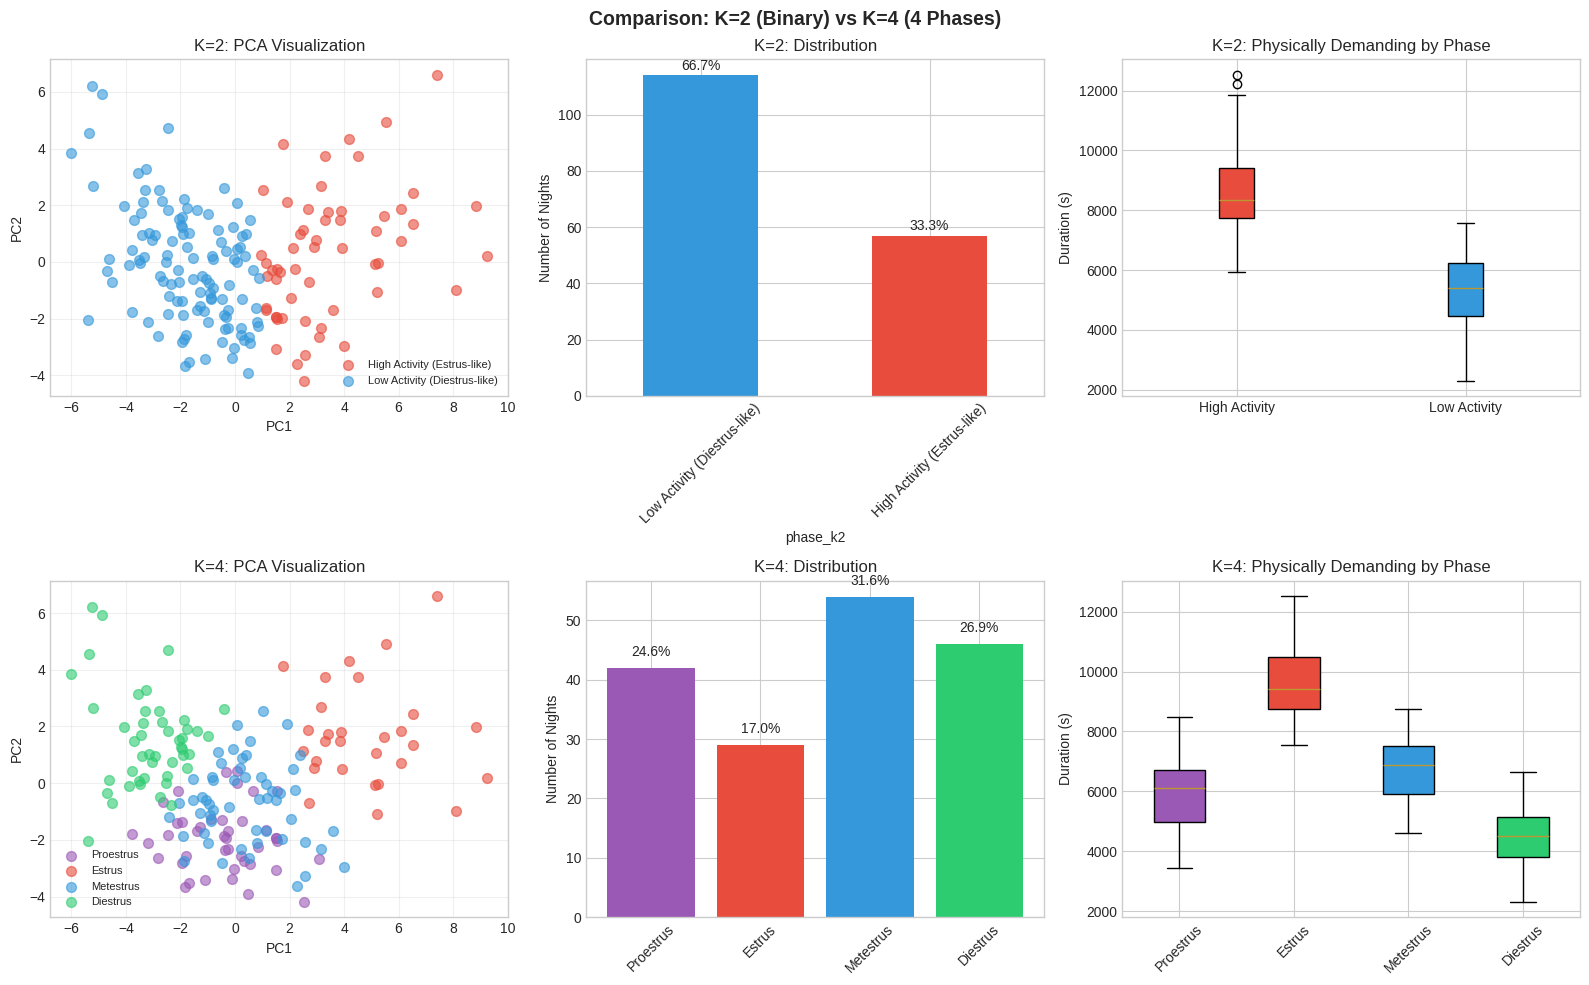

In [28]:
# Define colors
colors_k2 = {'High Activity (Estrus-like)': '#e74c3c', 'Low Activity (Diestrus-like)': '#3498db'}
colors_k4 = {'Proestrus': '#9b59b6', 'Estrus': '#e74c3c', 'Metestrus': '#3498db', 'Diestrus': '#2ecc71'}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: K=2
ax = axes[0, 0]
for phase in df_analysis['phase_k2'].unique():
    mask = df_analysis['phase_k2'] == phase
    ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
               c=colors_k2.get(phase, 'gray'), label=phase, alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K=2: PCA Visualization')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
k2_counts.plot(kind='bar', ax=ax, color=[colors_k2.get(x, 'gray') for x in k2_counts.index])
ax.set_title('K=2: Distribution')
ax.set_ylabel('Number of Nights')
ax.tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(k2_counts.items()):
    ax.text(i, val + 2, f'{100*val/len(df_analysis):.1f}%', ha='center', fontsize=10)

ax = axes[0, 2]
data_k2 = [df_analysis[df_analysis['phase_k2'] == p]['physically_demanding'].dropna() 
           for p in ['High Activity (Estrus-like)', 'Low Activity (Diestrus-like)'] 
           if p in df_analysis['phase_k2'].values]
labels_k2_box = [p for p in ['High Activity (Estrus-like)', 'Low Activity (Diestrus-like)'] 
                 if p in df_analysis['phase_k2'].values]
bp = ax.boxplot(data_k2, labels=['High Activity', 'Low Activity'], patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors_k2.get(labels_k2_box[i], 'gray'))
ax.set_title('K=2: Physically Demanding by Phase')
ax.set_ylabel('Duration (s)')

# Row 2: K=4
ax = axes[1, 0]
for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    mask = df_analysis['phase_k4'] == phase
    if mask.sum() > 0:
        ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
                   c=colors_k4.get(phase, 'gray'), label=phase, alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K=4: PCA Visualization')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
k4_order = ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']
k4_vals = [k4_counts.get(p, 0) for p in k4_order]
ax.bar(k4_order, k4_vals, color=[colors_k4[p] for p in k4_order])
ax.set_title('K=4: Distribution')
ax.set_ylabel('Number of Nights')
ax.tick_params(axis='x', rotation=45)
for i, val in enumerate(k4_vals):
    if val > 0:
        ax.text(i, val + 2, f'{100*val/len(df_analysis):.1f}%', ha='center', fontsize=10)

ax = axes[1, 2]
data_k4 = [df_analysis[df_analysis['phase_k4'] == p]['physically_demanding'].dropna() 
           for p in k4_order if p in df_analysis['phase_k4'].values]
labels_k4_box = [p for p in k4_order if p in df_analysis['phase_k4'].values]
bp = ax.boxplot(data_k4, labels=labels_k4_box, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors_k4.get(labels_k4_box[i], 'gray'))
ax.set_title('K=4: Physically Demanding by Phase')
ax.set_ylabel('Duration (s)')
ax.tick_params(axis='x', rotation=45)

plt.suptitle('Comparison: K=2 (Binary) vs K=4 (4 Phases)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7.8 Summary Comparison Table

In [29]:
# Calculate metrics
sil_k2 = silhouette_score(X_scaled, df_analysis['cluster_k2'])
sil_k4 = silhouette_score(X_scaled, df_analysis['cluster_k4'])

high_pct = 100 * k2_counts.get('High Activity (Estrus-like)', 0) / len(df_analysis)
low_pct = 100 * k2_counts.get('Low Activity (Diestrus-like)', 0) / len(df_analysis)

print("="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)

print(f"""
┌────────────────────────────┬─────────────────────────┬─────────────────────────┐
│ Metric                     │ K=2 (Binary)            │ K=4 (4 Phases)          │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Silhouette Score           │ {sil_k2:.3f}                   │ {sil_k4:.3f}                   │
│ Better separated?          │ {'YES ✓' if sil_k2 > sil_k4 else 'NO':<23} │ {'YES ✓' if sil_k4 > sil_k2 else 'NO':<23} │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Significant ANOVA features │ {sig_k2}/{len(key_features)}                     │ {sig_k4}/{len(key_features)}                     │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Distribution               │ High: {high_pct:.1f}%             │ Varies                  │
│                            │ Low: {low_pct:.1f}%              │                         │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Matches biology?           │ {'YES ✓' if 20 <= high_pct <= 40 else 'NO':<23} │ Check above             │
│ (Expected: 20-30% high)    │                         │                         │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Interpretation             │ Clear                   │ Ambiguous               │
└────────────────────────────┴─────────────────────────┴─────────────────────────┘
""")

SUMMARY COMPARISON TABLE

┌────────────────────────────┬─────────────────────────┬─────────────────────────┐
│ Metric                     │ K=2 (Binary)            │ K=4 (4 Phases)          │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Silhouette Score           │ 0.266                   │ 0.179                   │
│ Better separated?          │ YES ✓                   │ NO                      │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Significant ANOVA features │ 6/7                     │ 7/7                     │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Distribution               │ High: 33.3%             │ Varies                  │
│                            │ Low: 66.7%              │                         │
├────────────────────────────┼─────────────────────────┼─────────────────────────┤
│ Matches biology?           │ YES ✓                   │ Chec

---

# 8. Final Results & Recommendations

## 8.1 Summary

In [30]:
print("="*80)
print("PHASE 3 FINAL SUMMARY: Estrous Detection from Behavioral Data")
print("="*80)

print(f"""
DATASET:
--------
• Study: JAX Envision Morph2REP (Study 1001, v2025v3.3)
• Animals: {df_analysis['animal_id'].nunique()} female C57BL/6J mice (vehicle controls)
• Nights analyzed: {len(df_analysis)} (after cleaning)
• Features: {len(FEATURES)}
• Time period: Dark cycle (6 PM - 6 AM EST)

DATA CLEANING:
--------------
• Excluded cage change days (abnormal stress behavior)
• Excluded truncated end-of-study days (incomplete data)
• Excluded acclimation spillover

METHODOLOGY:
------------
Following Khatiz et al. (2025):
1. Hierarchical clustering of features (Spearman correlation)
2. Factor Analysis with Varimax rotation
3. PCA for visualization
4. K-Means clustering of nights
5. ANOVA validation

KEY FINDINGS:
-------------
1. Optimal k by silhouette score: {optimal_k}
2. K=2 has better cluster separation (silhouette: {sil_k2:.3f} vs {sil_k4:.3f})
3. K=2 distribution ({high_pct:.1f}% high / {low_pct:.1f}% low) matches expected biology
4. Both K=2 and K=4 show significant ANOVA results

RECOMMENDATION:
---------------
Use K=2 BINARY CLASSIFICATION for downstream morphine analysis:

  ┌─────────────────────────────────────────────────────────┐
  │  HIGH ACTIVITY STATE (Estrus-like)                      │
  │  • {high_pct:.1f}% of nights                                    │
  │  • Likely corresponds to Proestrus + Estrus             │
  │  • Higher estrogen period                               │
  │  • More locomotion, climbing, exploration               │
  ├─────────────────────────────────────────────────────────┤
  │  LOW ACTIVITY STATE (Diestrus-like)                     │
  │  • {low_pct:.1f}% of nights                                    │
  │  • Likely corresponds to Metestrus + Diestrus           │
  │  • Lower estrogen period                                │
  │  • More sleep, feeding, less physical activity          │
  └─────────────────────────────────────────────────────────┘

IMPORTANT CAVEAT:
-----------------
Without vaginal cytology ground truth, these are BEHAVIORAL classifications
that we HYPOTHESIZE correspond to estrous phases. We cannot confirm true
hormonal status from behavior alone.

For morphine analysis, we can ask:
"Does morphine response differ between High vs Low activity behavioral states?"
rather than claiming to know exact estrous phases.
""")

PHASE 3 FINAL SUMMARY: Estrous Detection from Behavioral Data

DATASET:
--------
• Study: JAX Envision Morph2REP (Study 1001, v2025v3.3)
• Animals: 18 female C57BL/6J mice (vehicle controls)
• Nights analyzed: 171 (after cleaning)
• Features: 21
• Time period: Dark cycle (6 PM - 6 AM EST)

DATA CLEANING:
--------------
• Excluded cage change days (abnormal stress behavior)
• Excluded truncated end-of-study days (incomplete data)
• Excluded acclimation spillover

METHODOLOGY:
------------
Following Khatiz et al. (2025):
1. Hierarchical clustering of features (Spearman correlation)
2. Factor Analysis with Varimax rotation
3. PCA for visualization
4. K-Means clustering of nights
5. ANOVA validation

KEY FINDINGS:
-------------
1. Optimal k by silhouette score: 2
2. K=2 has better cluster separation (silhouette: 0.266 vs 0.179)
3. K=2 distribution (33.3% high / 66.7% low) matches expected biology
4. Both K=2 and K=4 show significant ANOVA results

RECOMMENDATION:
---------------
Use K=2 BI

## 8.2 Save Results

In [31]:
# Save results
output_file = 'phase3_estrous_classification_final.csv'
df_analysis.to_csv(output_file, index=False)

print(f"Results saved to: {output_file}")
print(f"\nKey columns:")
print(f"  • cage_id, animal_id, night_date: Identifiers")
print(f"  • cluster_k2, phase_k2: Binary classification")
print(f"  • cluster_k4, phase_k4: 4-phase classification")
print(f"  • PC1-PC5: Principal component coordinates")
print(f"  • All behavioral features: For downstream analysis")

Results saved to: phase3_estrous_classification_final.csv

Key columns:
  • cage_id, animal_id, night_date: Identifiers
  • cluster_k2, phase_k2: Binary classification
  • cluster_k4, phase_k4: 4-phase classification
  • PC1-PC5: Principal component coordinates
  • All behavioral features: For downstream analysis


---

# Appendix: Technical Reference

## A.1 Glossary of Statistical Methods

| Method | What It Does | When to Use |
|--------|--------------|-------------|
| **Spearman Correlation** | Measures monotonic relationship between variables using ranks | Non-normal data, outliers present |
| **Hierarchical Clustering** | Groups items by similarity, creates tree structure | Exploring relationships without predefined k |
| **Factor Analysis** | Finds latent variables underlying observed features | Reducing many variables to interpretable dimensions |
| **PCA** | Linear projection maximizing variance | Dimensionality reduction, visualization |
| **K-Means** | Partitions data into k groups minimizing within-cluster variance | When you know (or hypothesize) number of groups |
| **Silhouette Score** | Measures cluster separation quality | Choosing optimal k |
| **ANOVA** | Tests if group means differ significantly | Validating that clusters are distinct |

## A.2 Key References

1. **Khatiz et al. (2025)** - Frontiers in Neuroscience 19:1509822
   - Validated behavioral estrous detection with vaginal cytology
   - Our methodology is based on their approach

2. **Levy et al. (2023)** - Found estrous explains ~3% of behavioral variance
   - Explains why we don't see dramatic cluster separation

## A.3 Reproducibility

- Random seed: 42 (for K-Means, Factor Analysis)
- Data version: 2025v3.3
- Analysis date: February 2025

TIME SERIES VISUALIZATION: Estrous-Like States Over Time


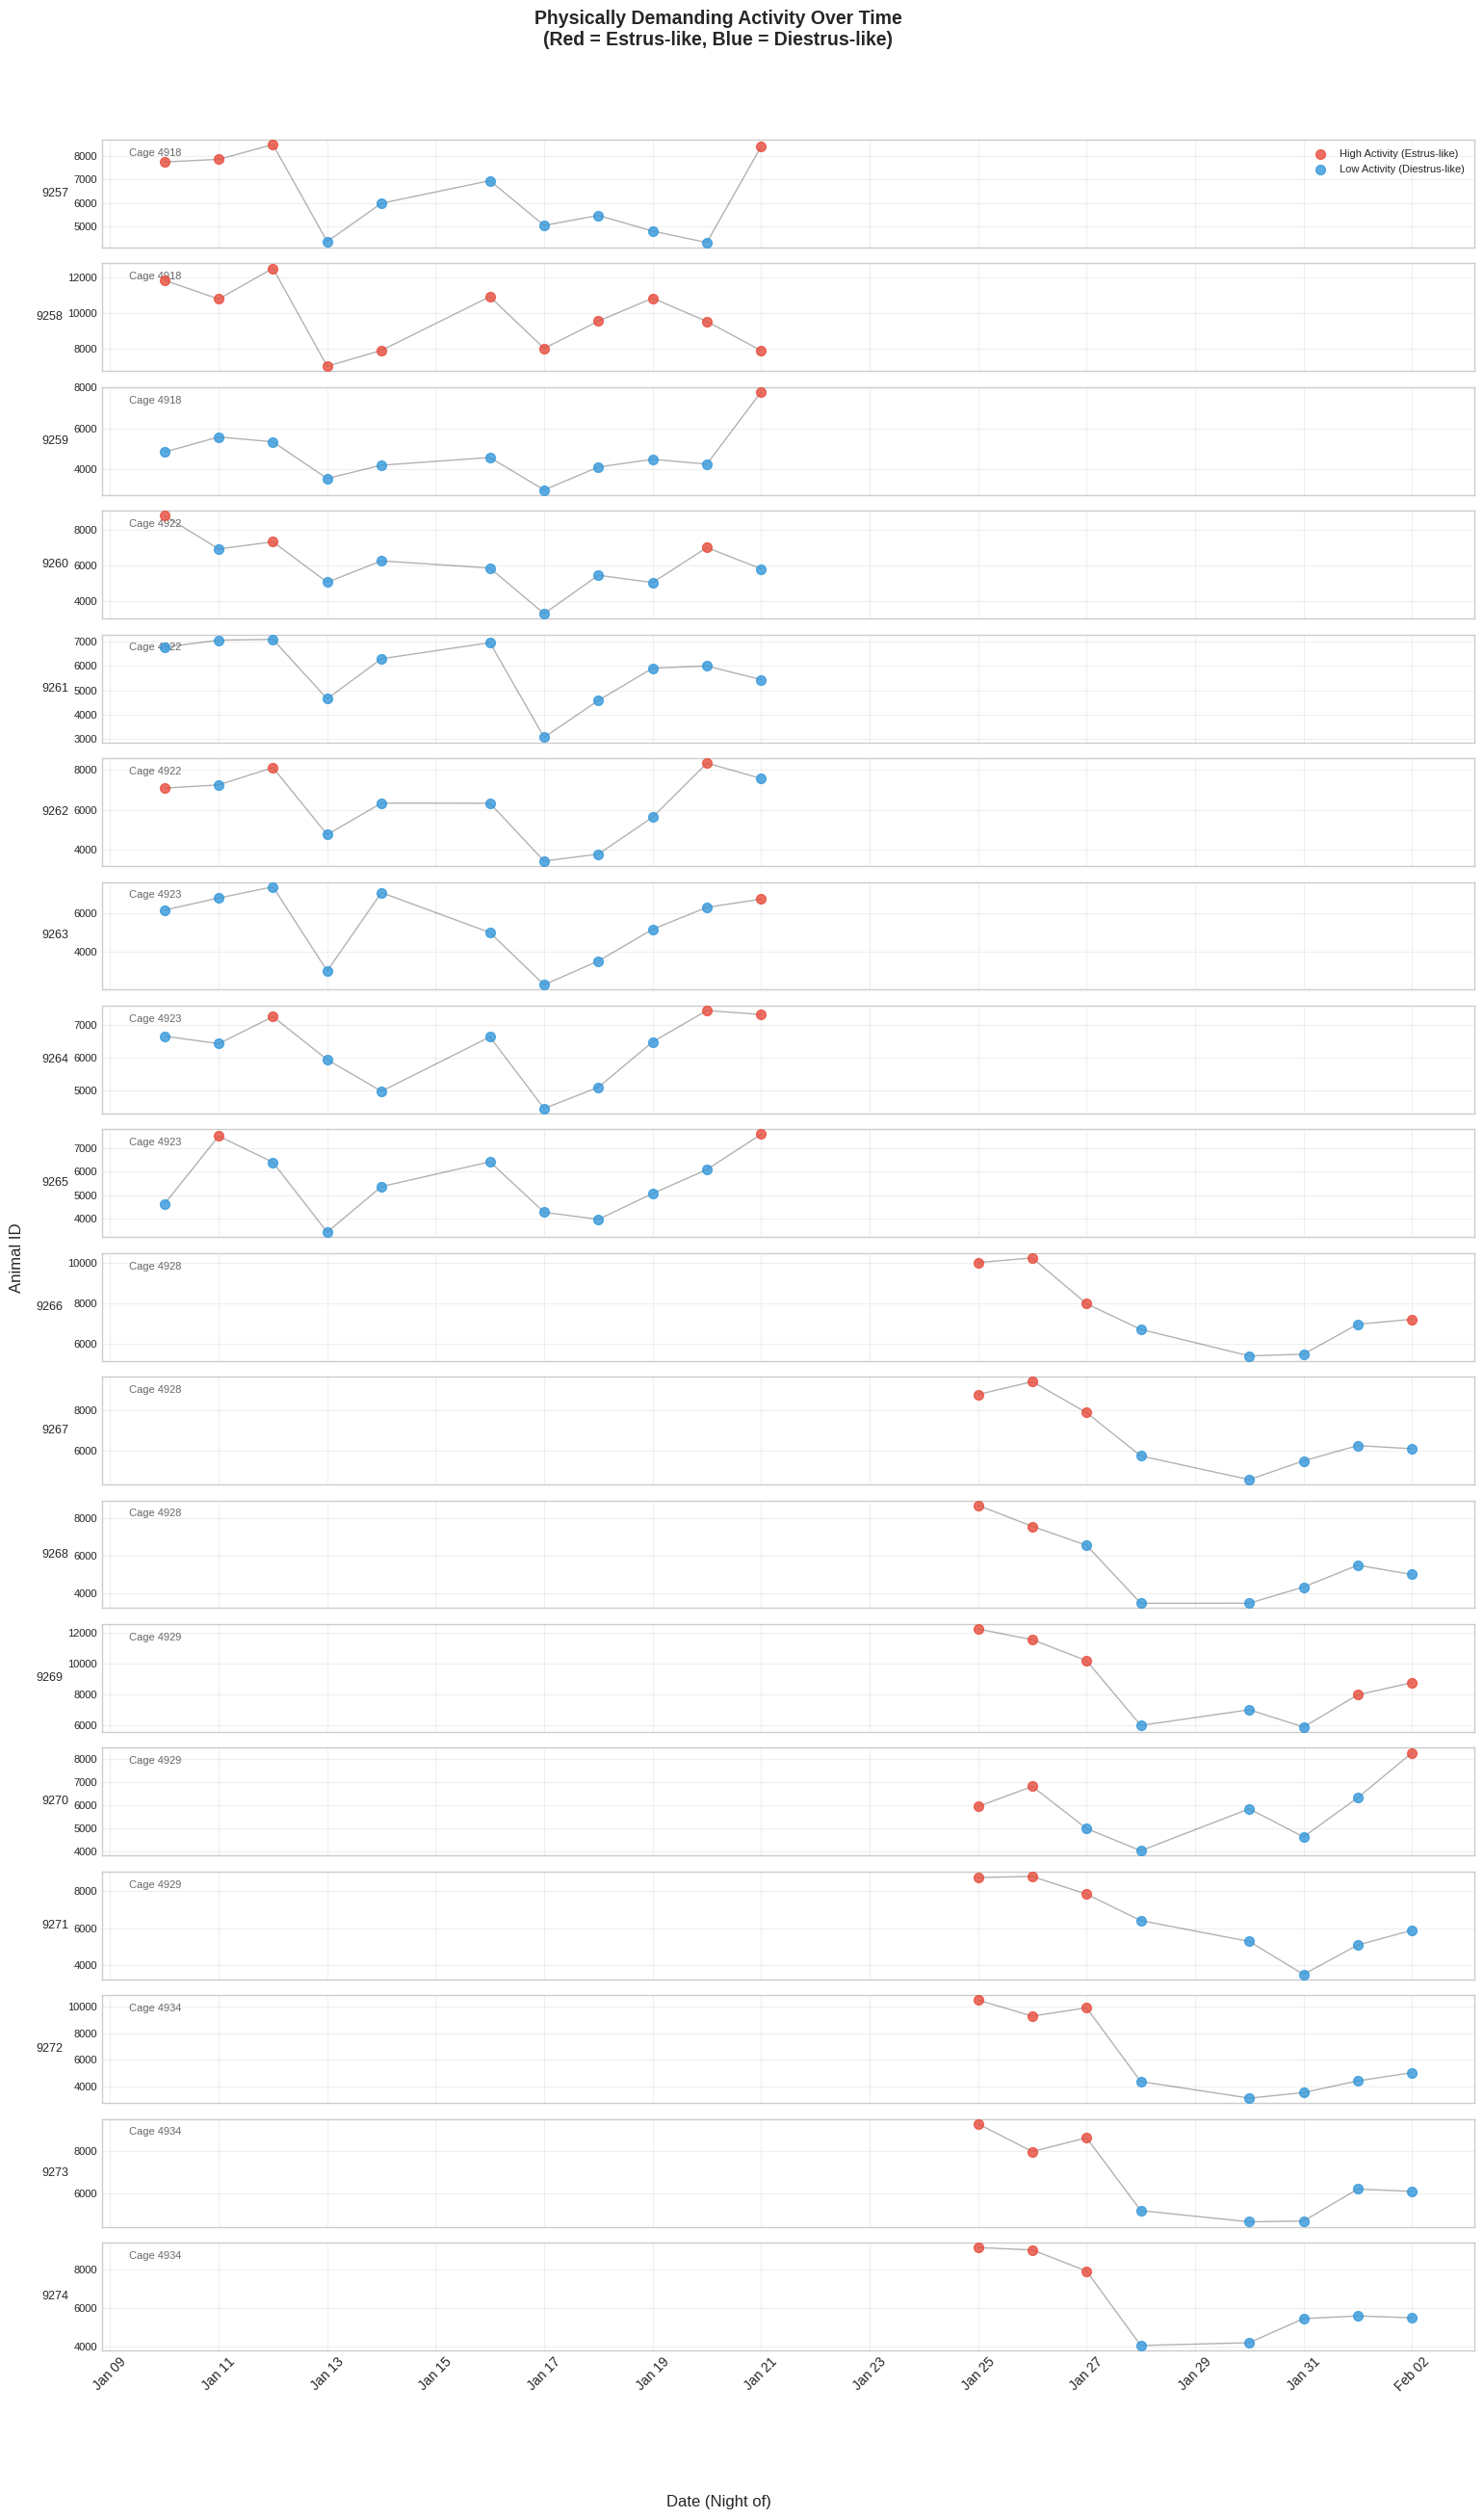


Saved: estrous_timeseries_all_animals.png

HEATMAP: Estrous Classification by Animal and Date


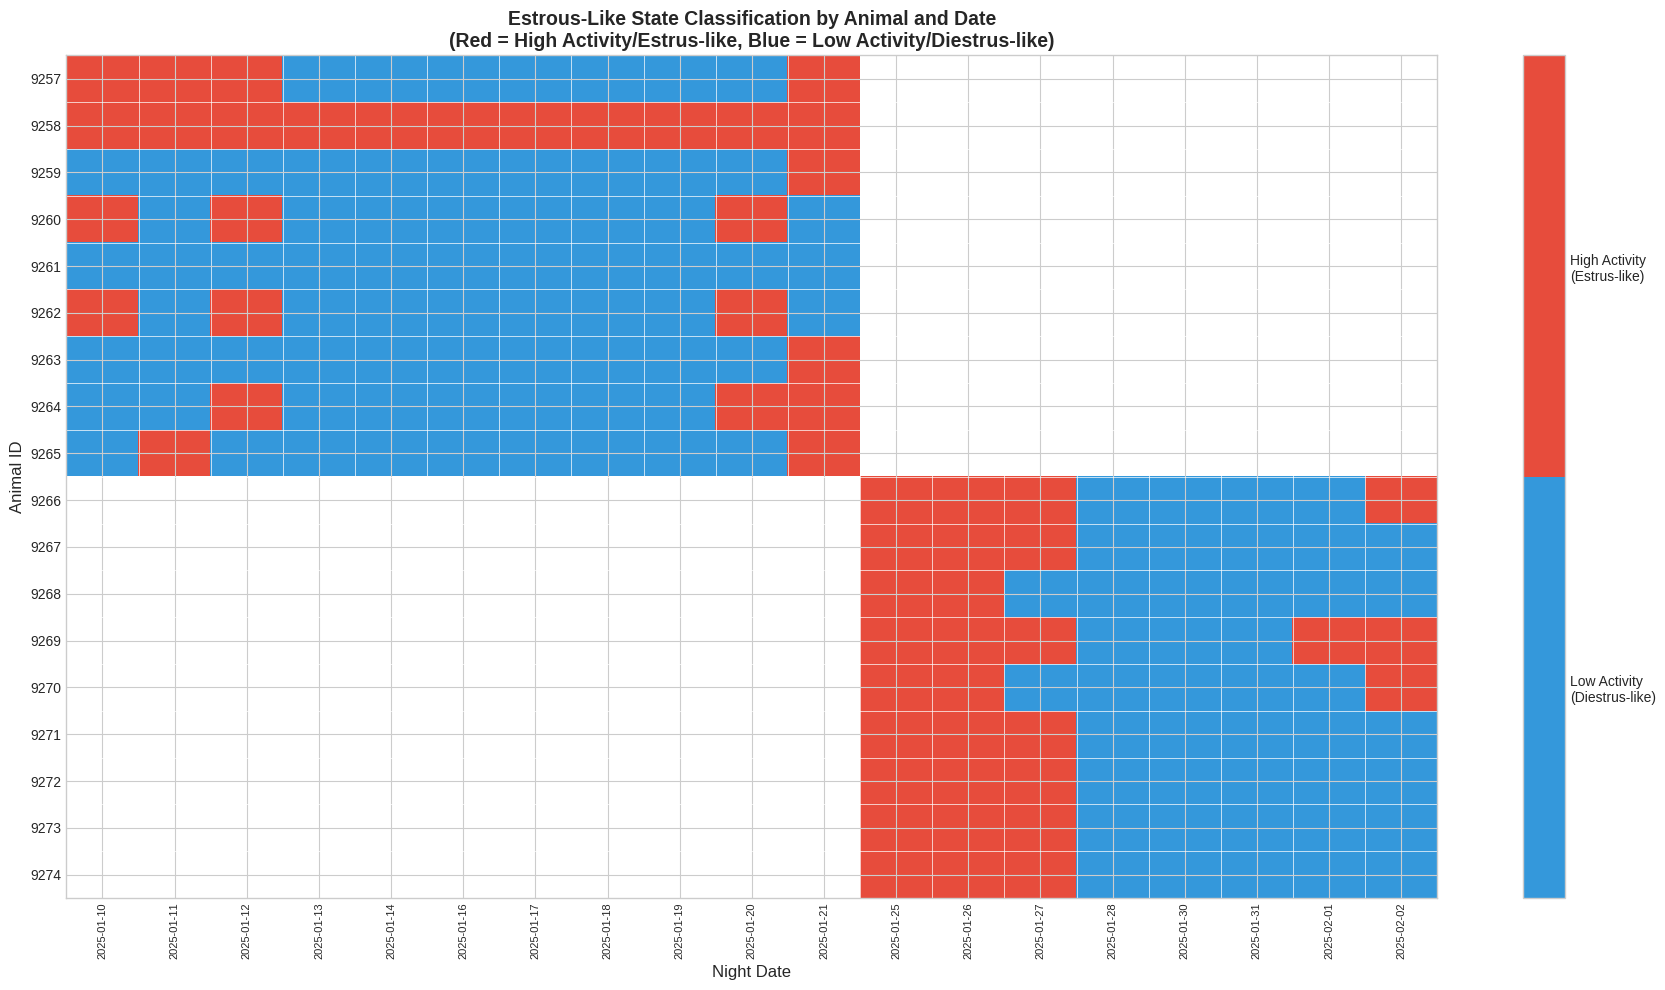


Saved: estrous_heatmap.png

CYCLE ANALYSIS: Is There a ~4-5 Day Pattern?


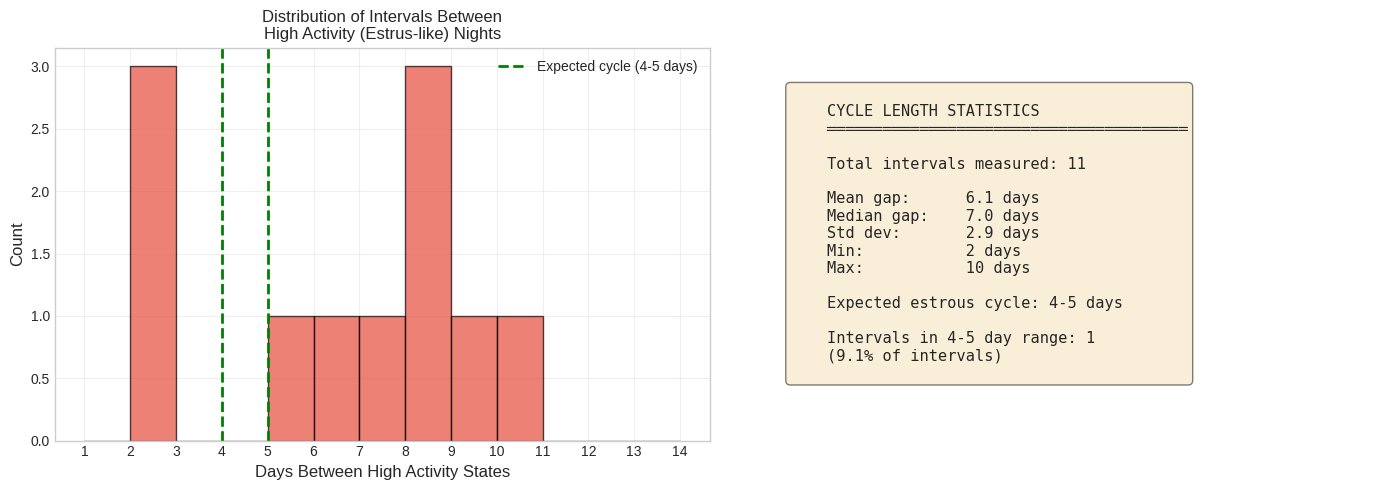


Saved: estrous_cycle_analysis.png

INDIVIDUAL ANIMAL TIME SERIES (with expected cycle)


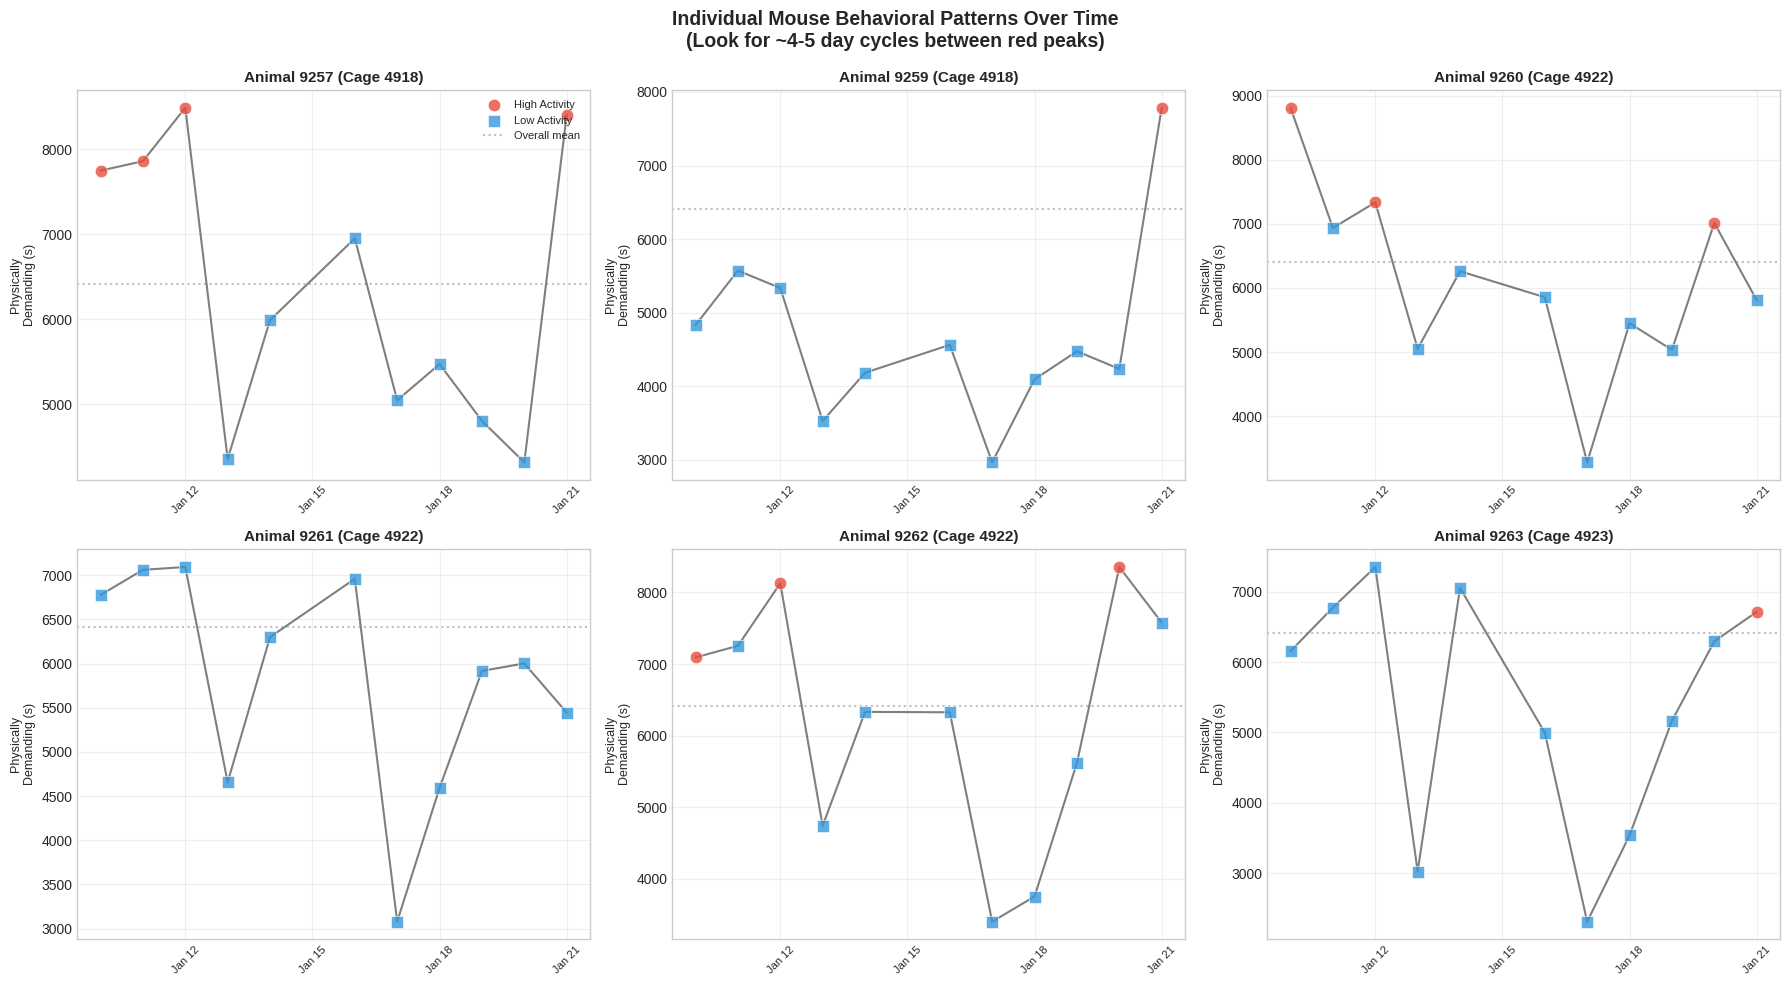


Saved: estrous_individual_animals.png

SUMMARY: Estrous-Like State Distribution Over Time

High Activity nights by date:
night_date  high_activity_count  total_animals  high_activity_pct
2025-01-10                    4              9          44.444444
2025-01-11                    3              9          33.333333
2025-01-12                    5              9          55.555556
2025-01-13                    1              9          11.111111
2025-01-14                    1              9          11.111111
2025-01-16                    1              9          11.111111
2025-01-17                    1              9          11.111111
2025-01-18                    1              9          11.111111
2025-01-19                    1              9          11.111111
2025-01-20                    4              9          44.444444
2025-01-21                    6              9          66.666667
2025-01-25                    9              9         100.000000
2025-01-26          

In [32]:
# =============================================================================
# TIME SERIES VISUALIZATION: When Do Estrous-Like States Occur?
# =============================================================================
# Run this after the Phase 3 notebook to visualize estrous patterns over time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Assuming df_analysis is already loaded with phase_k2 classification

# Convert night_date to datetime for plotting
df_analysis['night_date_dt'] = pd.to_datetime(df_analysis['night_date'])

# =============================================================================
# PLOT 1: All animals - Time series of physically_demanding with estrous overlay
# =============================================================================

print("="*80)
print("TIME SERIES VISUALIZATION: Estrous-Like States Over Time")
print("="*80)

# Create figure with subplots for each animal
animals = sorted(df_analysis['animal_id'].unique())
n_animals = len(animals)

fig, axes = plt.subplots(n_animals, 1, figsize=(16, n_animals * 1.5), sharex=True)
if n_animals == 1:
    axes = [axes]

colors = {'High Activity (Estrus-like)': '#e74c3c', 'Low Activity (Diestrus-like)': '#3498db'}

for idx, animal_id in enumerate(animals):
    ax = axes[idx]
    animal_data = df_analysis[df_analysis['animal_id'] == animal_id].sort_values('night_date_dt')
    
    # Plot physically_demanding as line
    ax.plot(animal_data['night_date_dt'], animal_data['physically_demanding'], 
            'k-', alpha=0.3, linewidth=1)
    
    # Scatter points colored by classification
    for phase in ['High Activity (Estrus-like)', 'Low Activity (Diestrus-like)']:
        mask = animal_data['phase_k2'] == phase
        ax.scatter(animal_data.loc[mask, 'night_date_dt'], 
                   animal_data.loc[mask, 'physically_demanding'],
                   c=colors[phase], s=50, alpha=0.8, 
                   label=phase if idx == 0 else '', zorder=5)
    
    # Formatting
    ax.set_ylabel(f'{animal_id}', fontsize=9, rotation=0, ha='right', va='center')
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add cage info
    cage_id = animal_data['cage_id'].iloc[0]
    ax.text(0.02, 0.85, f'Cage {cage_id}', transform=ax.transAxes, fontsize=8, alpha=0.7)

# Add legend to first subplot
axes[0].legend(loc='upper right', fontsize=8)

# Format x-axis
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
axes[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# Labels
fig.suptitle('Physically Demanding Activity Over Time\n(Red = Estrus-like, Blue = Diestrus-like)', 
             fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Animal ID', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.02, 'Date (Night of)', ha='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.08, top=0.93)
plt.savefig('estrous_timeseries_all_animals.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: estrous_timeseries_all_animals.png")


# =============================================================================
# PLOT 2: Heatmap - Estrous state by animal and date
# =============================================================================

print("\n" + "="*80)
print("HEATMAP: Estrous Classification by Animal and Date")
print("="*80)

# Create pivot table: animal_id x night_date, values = 1 if High Activity, 0 if Low
df_analysis['estrous_binary'] = (df_analysis['phase_k2'] == 'High Activity (Estrus-like)').astype(int)

# Pivot
pivot = df_analysis.pivot_table(
    index='animal_id', 
    columns='night_date', 
    values='estrous_binary',
    aggfunc='first'
)

# Sort by date
pivot = pivot[sorted(pivot.columns)]

# Plot heatmap
fig, ax = plt.subplots(figsize=(18, 10))

# Custom colormap: blue for low activity, red for high activity
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#3498db', '#e74c3c'])

im = ax.imshow(pivot.values, aspect='auto', cmap=cmap, vmin=0, vmax=1)

# Labels
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([str(d) for d in pivot.columns], rotation=90, fontsize=8)

ax.set_xlabel('Night Date', fontsize=12)
ax.set_ylabel('Animal ID', fontsize=12)
ax.set_title('Estrous-Like State Classification by Animal and Date\n(Red = High Activity/Estrus-like, Blue = Low Activity/Diestrus-like)', 
             fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Low Activity\n(Diestrus-like)', 'High Activity\n(Estrus-like)'])

# Add grid lines
ax.set_xticks(np.arange(-0.5, len(pivot.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(pivot.index), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=0.5)

plt.tight_layout()
plt.savefig('estrous_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: estrous_heatmap.png")


# =============================================================================
# PLOT 3: Cycle detection - Do we see ~4-5 day periodicity?
# =============================================================================

print("\n" + "="*80)
print("CYCLE ANALYSIS: Is There a ~4-5 Day Pattern?")
print("="*80)

# For each animal, calculate days between consecutive "High Activity" states
cycle_lengths = []

for animal_id in animals:
    animal_data = df_analysis[df_analysis['animal_id'] == animal_id].sort_values('night_date_dt')
    high_activity_dates = animal_data[animal_data['phase_k2'] == 'High Activity (Estrus-like)']['night_date_dt'].values
    
    if len(high_activity_dates) > 1:
        # Find gaps between high activity nights
        for i in range(len(high_activity_dates) - 1):
            gap = (high_activity_dates[i+1] - high_activity_dates[i]) / np.timedelta64(1, 'D')
            # Only count gaps > 1 (i.e., not consecutive high activity nights)
            if gap > 1:
                cycle_lengths.append({
                    'animal_id': animal_id,
                    'gap_days': gap
                })

if cycle_lengths:
    df_cycles = pd.DataFrame(cycle_lengths)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of gap lengths
    ax = axes[0]
    ax.hist(df_cycles['gap_days'], bins=range(1, 15), edgecolor='black', alpha=0.7, color='#e74c3c')
    ax.axvline(x=4, color='green', linestyle='--', linewidth=2, label='Expected cycle (4-5 days)')
    ax.axvline(x=5, color='green', linestyle='--', linewidth=2)
    ax.set_xlabel('Days Between High Activity States', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution of Intervals Between\nHigh Activity (Estrus-like) Nights', fontsize=12)
    ax.legend()
    ax.set_xticks(range(1, 15))
    ax.grid(True, alpha=0.3)
    
    # Summary stats
    ax = axes[1]
    ax.axis('off')
    
    stats_text = f"""
    CYCLE LENGTH STATISTICS
    ═══════════════════════════════════════
    
    Total intervals measured: {len(df_cycles)}
    
    Mean gap:      {df_cycles['gap_days'].mean():.1f} days
    Median gap:    {df_cycles['gap_days'].median():.1f} days
    Std dev:       {df_cycles['gap_days'].std():.1f} days
    Min:           {df_cycles['gap_days'].min():.0f} days
    Max:           {df_cycles['gap_days'].max():.0f} days
    
    Expected estrous cycle: 4-5 days
    
    Intervals in 4-5 day range: {((df_cycles['gap_days'] >= 4) & (df_cycles['gap_days'] <= 5)).sum()}
    ({100 * ((df_cycles['gap_days'] >= 4) & (df_cycles['gap_days'] <= 5)).mean():.1f}% of intervals)
    """
    
    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('estrous_cycle_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: estrous_cycle_analysis.png")
else:
    print("Not enough data to analyze cycle lengths")


# =============================================================================
# PLOT 4: Individual animal deep dive (top 6 animals by data points)
# =============================================================================

print("\n" + "="*80)
print("INDIVIDUAL ANIMAL TIME SERIES (with expected cycle)")
print("="*80)

# Select animals with most data
animal_counts = df_analysis.groupby('animal_id').size().sort_values(ascending=False)
top_animals = animal_counts.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, animal_id in enumerate(top_animals):
    ax = axes[idx]
    animal_data = df_analysis[df_analysis['animal_id'] == animal_id].sort_values('night_date_dt')
    cage_id = animal_data['cage_id'].iloc[0]
    
    # Plot line
    ax.plot(animal_data['night_date_dt'], animal_data['physically_demanding'], 
            'k-', alpha=0.5, linewidth=1.5)
    
    # Scatter by phase
    for phase in ['High Activity (Estrus-like)', 'Low Activity (Diestrus-like)']:
        mask = animal_data['phase_k2'] == phase
        marker = 'o' if phase == 'High Activity (Estrus-like)' else 's'
        ax.scatter(animal_data.loc[mask, 'night_date_dt'], 
                   animal_data.loc[mask, 'physically_demanding'],
                   c=colors[phase], s=80, alpha=0.8, marker=marker,
                   label=phase.split(' (')[0], zorder=5, edgecolors='white', linewidth=0.5)
    
    # Add horizontal line for threshold (mean)
    threshold = df_analysis['physically_demanding'].mean()
    ax.axhline(y=threshold, color='gray', linestyle=':', alpha=0.5, label='Overall mean')
    
    # Formatting
    ax.set_title(f'Animal {animal_id} (Cage {cage_id})', fontsize=11, fontweight='bold')
    ax.set_ylabel('Physically\nDemanding (s)', fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle('Individual Mouse Behavioral Patterns Over Time\n(Look for ~4-5 day cycles between red peaks)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('estrous_individual_animals.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: estrous_individual_animals.png")


# =============================================================================
# Summary statistics
# =============================================================================

print("\n" + "="*80)
print("SUMMARY: Estrous-Like State Distribution Over Time")
print("="*80)

# By date
print("\nHigh Activity nights by date:")
date_summary = df_analysis.groupby('night_date').agg({
    'estrous_binary': ['sum', 'count']
}).reset_index()
date_summary.columns = ['night_date', 'high_activity_count', 'total_animals']
date_summary['high_activity_pct'] = 100 * date_summary['high_activity_count'] / date_summary['total_animals']

print(date_summary.to_string(index=False))

print(f"\nMean % high activity per night: {date_summary['high_activity_pct'].mean():.1f}%")
print(f"Range: {date_summary['high_activity_pct'].min():.1f}% - {date_summary['high_activity_pct'].max():.1f}%")

# By animal
print("\n" + "-"*50)
print("High Activity nights by animal:")
animal_summary = df_analysis.groupby('animal_id').agg({
    'estrous_binary': ['sum', 'count']
}).reset_index()
animal_summary.columns = ['animal_id', 'high_activity_nights', 'total_nights']
animal_summary['high_activity_pct'] = 100 * animal_summary['high_activity_nights'] / animal_summary['total_nights']

print(animal_summary.to_string(index=False))

print(f"\nMean % high activity per animal: {animal_summary['high_activity_pct'].mean():.1f}%")
print(f"Expected (Proestrus + Estrus): 20-30%")

In [34]:
# Check Rep1 vs Rep2 batch effect
print("="*70)
print("BATCH EFFECT CHECK: Rep1 vs Rep2")
print("="*70)

# Add replicate info
df_analysis['replicate'] = df_analysis['night_date'].apply(
    lambda x: 'Rep1' if x < date(2025, 1, 23) else 'Rep2'
)

# Compare
rep_comparison = df_analysis.groupby('replicate').agg({
    'physically_demanding': 'mean',
    'activity_amplitude': 'mean',
    'sleep_related': 'mean',
    'estrous_binary': 'mean'
}).round(1)

rep_comparison.columns = ['Phys. Demanding', 'Activity', 'Sleep', '% High Activity']
rep_comparison['% High Activity'] = (rep_comparison['% High Activity'] * 100).round(1)

print(rep_comparison.to_string())

# Statistical test
from scipy.stats import ttest_ind

rep1_phys = df_analysis[df_analysis['replicate'] == 'Rep1']['physically_demanding']
rep2_phys = df_analysis[df_analysis['replicate'] == 'Rep2']['physically_demanding']

t_stat, p_val = ttest_ind(rep1_phys, rep2_phys)
print(f"\nT-test (physically_demanding): t={t_stat:.2f}, p={p_val:.4f}")
print(f"Rep1 mean: {rep1_phys.mean():.1f}")
print(f"Rep2 mean: {rep2_phys.mean():.1f}")

if p_val < 0.05:
    print("\n⚠️ SIGNIFICANT BATCH EFFECT DETECTED!")
    print("The clustering is likely separating Rep1 vs Rep2, not estrous phases.")


BATCH EFFECT CHECK: Rep1 vs Rep2
           Phys. Demanding  Activity   Sleep  % High Activity
replicate                                                    
Rep1                6222.8   30137.5  3586.4             30.0
Rep2                6669.1   28697.9  4018.0             40.0

T-test (physically_demanding): t=-1.42, p=0.1584
Rep1 mean: 6222.8
Rep2 mean: 6669.1
